In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, GRU
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras import callbacks

In [2]:
file_path_1 = 'data/domain1_train.json'
df1 = pd.read_json(file_path_1, lines=True)
file_path_2 = 'data/domain2_train.json'
df2 = pd.read_json(file_path_2, lines=True).drop('model', axis=1)
df_comb = pd.concat([df1, df2],axis=0,ignore_index=True)

X = np.array(df_comb['text'])
y = np.array(df_comb['label'])
# 5-fold cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [3]:
def vanilla_rnn():
    model = Sequential()
    model.add(GRU(hidden_layers, input_shape = (maxlen,1), return_sequences = False))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()
    
    adam = optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [4]:
# Initialize a list to store the results (e.g., accuracy scores)

num_classes = 2
batch_size = 32
n_epochs = 20
early_stop_patience = 2
earlystopping = callbacks.EarlyStopping(monitor="accuracy",
                                        mode="max", patience=early_stop_patience,
                                        restore_best_weights=True)
maxlen_lis = [50, 80, 110, 140]
learning_rate_lis = [0.0005, 0.002, 0.005, 0.01]
hidden_layers_lis = [32, 64, 128, 256]


test_acc_dict = {}
for maxlen in maxlen_lis:
    for learning_rate in learning_rate_lis:
        for hidden_layers in hidden_layers_lis:
            results = []
            # Iterate through each fold CV
            for train_idx, val_idx in cv.split(X, y):
                # Split the data into training and validation sets for this fold
                X_train, X_test = X[train_idx], X[val_idx]
                y_train, y_test = y[train_idx], y[val_idx]

                X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
                X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
                X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
                X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))
                y_train = to_categorical(y_train, num_classes)
                y_test = to_categorical(y_test, num_classes)

                # Create the model
                model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)

                # Train the model on the training data for this fold
                model.fit(X_train, y_train, callbacks=[earlystopping])

                # Evaluate the model on the validation data for this fold
                y_pred = model.predict(X_test)
                y_test_ = np.argmax(y_test, axis = 1)
                accuracy = accuracy_score(y_pred, y_test_)
                
                # Store the accuracy in the results list
                results.append(accuracy)

            # Calculate and print the mean and standard deviation of the accuracies
            mean_accuracy = np.mean(results)
            test_acc_dict['maxlen'+str(maxlen)+'lr'+str(learning_rate)+'unit'+str(hidden_layers)] = mean_accuracy
            
            file_path_test = 'data/test_set.json'
            df_test = pd.read_json(file_path_test, lines=True)
            X_Kaggle = np.array(df_test['text'])
            X_Kaggle = pad_sequences(X_Kaggle, padding='post', maxlen=maxlen)
            X_Kaggle = np.array(X_Kaggle).reshape((X_Kaggle.shape[0], X_Kaggle.shape[1], 1))            
            y_Kaggle = model.predict(X_Kaggle)
            df_test['class'] = y_Kaggle
            selected_columns = ['id', 'class'] 
            df_test[selected_columns].to_csv('prediction/'+'len'+str(maxlen)+'lr'+str(learning_rate)+'unit'+str(hidden_layers)+'.csv', index=False)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 3,426
Trainable params: 3,426
Non-trainable params: 0
_________________________________________________________________


C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 5s 5ms/step - loss: 0.5455 - accuracy: 0.7131
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4688 - accuracy: 0.7917
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4099 - accuracy: 0.8295
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3924 - accuracy: 0.8398
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3819 - accuracy: 0.8465
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3765 - accuracy: 0.8495
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3703 - accuracy: 0.8538
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3670 - accuracy: 0.8565
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3632 - accuracy: 0.8586
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3586 - accuracy: 0.8598

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.5378 - accuracy: 0.7246
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4538 - accuracy: 0.8021
Epoch 3/20
860/860 [==============================] - 5s 5ms/step - loss: 0.4054 - accuracy: 0.8325
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3857 - accuracy: 0.8443
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3776 - accuracy: 0.8488
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3722 - accuracy: 0.8533
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3678 - accuracy: 0.8558
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3640 - accuracy: 0.8602
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3608 - accuracy: 0.8602
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3585 - accuracy: 0.8614
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.5361 - accuracy: 0.7307
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4514 - accuracy: 0.8058
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4034 - accuracy: 0.8328
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3867 - accuracy: 0.8431
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3779 - accuracy: 0.8486
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3727 - accuracy: 0.8529
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3680 - accuracy: 0.8545
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3654 - accuracy: 0.8566
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3606 - accuracy: 0.8592
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3580 - accuracy: 0.8617
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.5509 - accuracy: 0.7111
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4569 - accuracy: 0.8045
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4036 - accuracy: 0.8343
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3877 - accuracy: 0.8454
Epoch 5/20
860/860 [==============================] - 4s 4ms/step - loss: 0.3802 - accuracy: 0.8484
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3756 - accuracy: 0.8509
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3708 - accuracy: 0.8538
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3689 - accuracy: 0.8555
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3656 - accuracy: 0.8575
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3620 - accuracy: 0.8588
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.5678 - accuracy: 0.6928
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.5300 - accuracy: 0.7403
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.4562 - accuracy: 0.8022
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3996 - accuracy: 0.8351
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3795 - accuracy: 0.8468
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3736 - accuracy: 0.8513
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3661 - accuracy: 0.8569
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3638 - accuracy: 0.8585
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3617 - accuracy: 0.8603
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3577 - accuracy: 0.8622
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5432 - accuracy: 0.7218
Epoch 2/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4947 - accuracy: 0.7715
Epoch 3/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4229 - accuracy: 0.8202
Epoch 4/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3956 - accuracy: 0.8384
Epoch 5/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3786 - accuracy: 0.8483
Epoch 6/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3706 - accuracy: 0.8522
Epoch 7/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3656 - accuracy: 0.8566
Epoch 8/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3602 - accuracy: 0.8593
Epoch 9/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3568 - accuracy: 0.8608
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3548 - accuracy: 0.8614
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 7s 8ms/step - loss: 0.5418 - accuracy: 0.7233
Epoch 2/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4981 - accuracy: 0.7703
Epoch 3/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4212 - accuracy: 0.8234
Epoch 4/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3909 - accuracy: 0.8404
Epoch 5/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3783 - accuracy: 0.8464
Epoch 6/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3693 - accuracy: 0.8530
Epoch 7/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3646 - accuracy: 0.8549
Epoch 8/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3598 - accuracy: 0.8585
Epoch 9/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3562 - accuracy: 0.8584
Epoch 10/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3553 - accuracy: 0.8608
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 7s 7ms/step - loss: 0.5426 - accuracy: 0.7254
Epoch 2/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4733 - accuracy: 0.7869
Epoch 3/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4034 - accuracy: 0.8332
Epoch 4/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3856 - accuracy: 0.8429
Epoch 5/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3756 - accuracy: 0.8497
Epoch 6/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3713 - accuracy: 0.8518
Epoch 7/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3664 - accuracy: 0.8562
Epoch 8/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3624 - accuracy: 0.8582
Epoch 9/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3579 - accuracy: 0.8619
Epoch 10/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3563 - accuracy: 0.8619
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 7s 7ms/step - loss: 0.5466 - accuracy: 0.7181
Epoch 2/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4809 - accuracy: 0.7843
Epoch 3/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4093 - accuracy: 0.8314
Epoch 4/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3861 - accuracy: 0.8436
Epoch 5/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3782 - accuracy: 0.8495
Epoch 6/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3723 - accuracy: 0.8519
Epoch 7/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3646 - accuracy: 0.8555
Epoch 8/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3624 - accuracy: 0.8586
Epoch 9/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3587 - accuracy: 0.8603
Epoch 10/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3573 - accuracy: 0.8609

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 7s 7ms/step - loss: 0.5353 - accuracy: 0.7310
Epoch 2/20
860/860 [==============================] - 6s 7ms/step - loss: 0.4661 - accuracy: 0.7935
Epoch 3/20
860/860 [==============================] - 6s 8ms/step - loss: 0.4082 - accuracy: 0.8302
Epoch 4/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3859 - accuracy: 0.8426
Epoch 5/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3729 - accuracy: 0.8501
Epoch 6/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3675 - accuracy: 0.8550
Epoch 7/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3628 - accuracy: 0.8566
Epoch 8/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3592 - accuracy: 0.8600
Epoch 9/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3556 - accuracy: 0.8609
Epoch 10/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3538 - accuracy: 0.8627
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 128)               50304     
                                                                 
 dense_10 (Dense)            (None, 2)                 258       
                                                                 
 activation_10 (Activation)  (None, 2)                 0         
                                                                 
Total params: 50,562
Trainable params: 50,562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 13s 14ms/step - loss: 0.5459 - accuracy: 0.7216
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4973 - accuracy: 0.7701
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4185 - accuracy: 0.8237
Epoch 4

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5390 - accuracy: 0.7319
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4717 - accuracy: 0.7888
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4081 - accuracy: 0.8303
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3860 - accuracy: 0.8423
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3753 - accuracy: 0.8496
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3679 - accuracy: 0.8518
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3616 - accuracy: 0.8560
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3560 - accuracy: 0.8595
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3510 - accuracy: 0.8624
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3506 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5437 - accuracy: 0.7248
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.4905 - accuracy: 0.7765
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4091 - accuracy: 0.8289
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3832 - accuracy: 0.8434
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3698 - accuracy: 0.8521
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3634 - accuracy: 0.8564
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3581 - accuracy: 0.8595
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3541 - accuracy: 0.8609
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3502 - accuracy: 0.8623
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3464 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5423 - accuracy: 0.7287
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4975 - accuracy: 0.7697
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4339 - accuracy: 0.8157
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3955 - accuracy: 0.8378
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3779 - accuracy: 0.8486
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3710 - accuracy: 0.8532
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3644 - accuracy: 0.8559
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3612 - accuracy: 0.8582
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3587 - accuracy: 0.8591
Epoch 10/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3561 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5362 - accuracy: 0.7350
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4783 - accuracy: 0.7831
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4005 - accuracy: 0.8343
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3793 - accuracy: 0.8481
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3667 - accuracy: 0.8552
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3616 - accuracy: 0.8573
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3536 - accuracy: 0.8625
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3478 - accuracy: 0.8645
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3429 - accuracy: 0.8673
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3385 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 256)               198912    
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
 activation_15 (Activation)  (None, 2)                 0         
                                                                 
Total params: 199,426
Trainable params: 199,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 47s 54ms/step - loss: 0.5419 - accuracy: 0.7322
Epoch 2/20
860/860 [==============================] - 47s 54ms/step - loss: 0.5121 - accuracy: 0.7579
Epoch 3/20
860/860 [==============================] - 47s 54ms/step - loss: 0.4416 - accuracy: 0.8112
Epoch

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 47s 53ms/step - loss: 0.5441 - accuracy: 0.7289
Epoch 2/20
860/860 [==============================] - 46s 54ms/step - loss: 0.5078 - accuracy: 0.7612
Epoch 3/20
860/860 [==============================] - 47s 54ms/step - loss: 0.4416 - accuracy: 0.8103
Epoch 4/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3939 - accuracy: 0.8384
Epoch 5/20
860/860 [==============================] - 47s 54ms/step - loss: 0.3725 - accuracy: 0.8509
Epoch 6/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3612 - accuracy: 0.8551
Epoch 7/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3502 - accuracy: 0.8609
Epoch 8/20
860/860 [==============================] - 47s 54ms/step - loss: 0.3424 - accuracy: 0.8644
Epoch 9/20
860/860 [==============================] - 47s 54ms/step - loss: 0.3351 - accuracy: 0.8673
Epoch 10/20
860/860 [==============================] - 46s 54ms/step - loss: 0.327

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 48s 55ms/step - loss: 0.5471 - accuracy: 0.7253
Epoch 2/20
860/860 [==============================] - 47s 55ms/step - loss: 0.5137 - accuracy: 0.7584
Epoch 3/20
860/860 [==============================] - 47s 55ms/step - loss: 0.4365 - accuracy: 0.8144
Epoch 4/20
860/860 [==============================] - 48s 56ms/step - loss: 0.3849 - accuracy: 0.8442
Epoch 5/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3661 - accuracy: 0.8549
Epoch 6/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3574 - accuracy: 0.8599
Epoch 7/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3484 - accuracy: 0.8633
Epoch 8/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3403 - accuracy: 0.8669
Epoch 9/20
860/860 [==============================] - 47s 55ms/step - loss: 0.3330 - accuracy: 0.8715
Epoch 10/20
860/860 [==============================] - 47s 55ms/step - loss: 0.328

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 49s 56ms/step - loss: 0.5433 - accuracy: 0.7298
Epoch 2/20
860/860 [==============================] - 48s 56ms/step - loss: 0.5229 - accuracy: 0.7480
Epoch 3/20
860/860 [==============================] - 48s 56ms/step - loss: 0.4548 - accuracy: 0.8015
Epoch 4/20
860/860 [==============================] - 49s 56ms/step - loss: 0.3967 - accuracy: 0.8356
Epoch 5/20
860/860 [==============================] - 48s 56ms/step - loss: 0.3743 - accuracy: 0.8491
Epoch 6/20
860/860 [==============================] - 48s 55ms/step - loss: 0.3609 - accuracy: 0.8561
Epoch 7/20
860/860 [==============================] - 49s 57ms/step - loss: 0.3520 - accuracy: 0.8609
Epoch 8/20
860/860 [==============================] - 48s 56ms/step - loss: 0.3436 - accuracy: 0.8652
Epoch 9/20
860/860 [==============================] - 49s 57ms/step - loss: 0.3355 - accuracy: 0.8690
Epoch 10/20
860/860 [==============================] - 48s 56ms/step - loss: 0.3277 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 51s 59ms/step - loss: 0.5415 - accuracy: 0.7307
Epoch 2/20
860/860 [==============================] - 51s 59ms/step - loss: 0.5138 - accuracy: 0.7567
Epoch 3/20
860/860 [==============================] - 51s 59ms/step - loss: 0.4386 - accuracy: 0.8107
Epoch 4/20
860/860 [==============================] - 51s 59ms/step - loss: 0.3917 - accuracy: 0.8393
Epoch 5/20
860/860 [==============================] - 51s 60ms/step - loss: 0.3696 - accuracy: 0.8521
Epoch 6/20
860/860 [==============================] - 51s 59ms/step - loss: 0.3533 - accuracy: 0.8600
Epoch 7/20
860/860 [==============================] - 51s 59ms/step - loss: 0.3481 - accuracy: 0.8627
Epoch 8/20
860/860 [==============================] - 51s 59ms/step - loss: 0.3400 - accuracy: 0.8663
Epoch 9/20
860/860 [==============================] - 51s 59ms/step - loss: 0.3368 - accuracy: 0.8685
Epoch 10/20
860/860 [==============================] - 51s 60ms/step - loss: 0.329

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4859 - accuracy: 0.7739
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3800 - accuracy: 0.8501
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3699 - accuracy: 0.8546
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3617 - accuracy: 0.8602
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3572 - accuracy: 0.8622
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3527 - accuracy: 0.8638
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3491 - accuracy: 0.8664
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3452 - accuracy: 0.8680
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3411 - accuracy: 0.8706
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3368 - accuracy: 0.8737
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4755 - accuracy: 0.7834
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3809 - accuracy: 0.8519
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3683 - accuracy: 0.8580
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3587 - accuracy: 0.8618
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3553 - accuracy: 0.8642
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3499 - accuracy: 0.8659
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3435 - accuracy: 0.8694
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3389 - accuracy: 0.8729
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3359 - accuracy: 0.8745
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3347 - accuracy: 0.8745
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4751 - accuracy: 0.7796
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3824 - accuracy: 0.8478
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3678 - accuracy: 0.8587
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3609 - accuracy: 0.8605
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3543 - accuracy: 0.8634
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3551 - accuracy: 0.8649
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3499 - accuracy: 0.8682
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3426 - accuracy: 0.8715
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3394 - accuracy: 0.8735
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3359 - accuracy: 0.8735
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4819 - accuracy: 0.7760
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3821 - accuracy: 0.8503
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3705 - accuracy: 0.8556
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3647 - accuracy: 0.8595
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3588 - accuracy: 0.8613
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3556 - accuracy: 0.8632
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3548 - accuracy: 0.8654
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3474 - accuracy: 0.8676
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3416 - accuracy: 0.8710
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3397 - accuracy: 0.8717
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4956 - accuracy: 0.7628
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3799 - accuracy: 0.8493
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3647 - accuracy: 0.8582
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3577 - accuracy: 0.8621
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3511 - accuracy: 0.8649
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3466 - accuracy: 0.8691
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3437 - accuracy: 0.8706
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3388 - accuracy: 0.8732
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3359 - accuracy: 0.8736
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3331 - accuracy: 0.8758
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_25 (GRU)                (None, 64)                12864     
                                                                 
 dense_25 (Dense)            (None, 2)                 130       
                                                                 
 activation_25 (Activation)  (None, 2)                 0         
                                                                 
Total params: 12,994
Trainable params: 12,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 8s 8ms/step - loss: 0.4969 - accuracy: 0.7649
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3820 - accuracy: 0.8473
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3632 - accuracy: 0.8590
Epoch 4/20
86

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 7s 8ms/step - loss: 0.4910 - accuracy: 0.7691
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3854 - accuracy: 0.8459
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3755 - accuracy: 0.8516
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3643 - accuracy: 0.8576
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3578 - accuracy: 0.8605
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3515 - accuracy: 0.8642
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3449 - accuracy: 0.8675
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3396 - accuracy: 0.8705
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3339 - accuracy: 0.8725
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3317 - accuracy: 0.8740
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5086 - accuracy: 0.7566
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3870 - accuracy: 0.8465
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3705 - accuracy: 0.8557
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3636 - accuracy: 0.8586
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3576 - accuracy: 0.8622
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3523 - accuracy: 0.8642
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3421 - accuracy: 0.8702
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3375 - accuracy: 0.8721
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3324 - accuracy: 0.8734
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3293 - accuracy: 0.8746
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4960 - accuracy: 0.7683
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3923 - accuracy: 0.8436
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3684 - accuracy: 0.8564
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3583 - accuracy: 0.8613
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3522 - accuracy: 0.8633
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3484 - accuracy: 0.8677
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3457 - accuracy: 0.8685
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3384 - accuracy: 0.8714
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3370 - accuracy: 0.8722
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3345 - accuracy: 0.8732
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 7s 8ms/step - loss: 0.4994 - accuracy: 0.7640
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3810 - accuracy: 0.8487
Epoch 3/20
860/860 [==============================] - 6s 8ms/step - loss: 0.3667 - accuracy: 0.8558
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3555 - accuracy: 0.8624
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3470 - accuracy: 0.8672
Epoch 6/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3420 - accuracy: 0.8720
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3355 - accuracy: 0.8733
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3305 - accuracy: 0.8758
Epoch 9/20
860/860 [==============================] - 6s 7ms/step - loss: 0.3272 - accuracy: 0.8761
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3237 - accuracy: 0.8764
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 15s 16ms/step - loss: 0.5100 - accuracy: 0.7549
Epoch 2/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3935 - accuracy: 0.8398
Epoch 3/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3685 - accuracy: 0.8545
Epoch 4/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3591 - accuracy: 0.8616
Epoch 5/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3514 - accuracy: 0.8641
Epoch 6/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3453 - accuracy: 0.8665
Epoch 7/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3375 - accuracy: 0.8702
Epoch 8/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3321 - accuracy: 0.8736
Epoch 9/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3281 - accuracy: 0.8751
Epoch 10/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3224 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 14s 16ms/step - loss: 0.5182 - accuracy: 0.7515
Epoch 2/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3974 - accuracy: 0.8392
Epoch 3/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3728 - accuracy: 0.8520
Epoch 4/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3640 - accuracy: 0.8552
Epoch 5/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3560 - accuracy: 0.8595
Epoch 6/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3501 - accuracy: 0.8619
Epoch 7/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3416 - accuracy: 0.8673
Epoch 8/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3371 - accuracy: 0.8697
Epoch 9/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3325 - accuracy: 0.8709
Epoch 10/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3273 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 15s 16ms/step - loss: 0.5260 - accuracy: 0.7441
Epoch 2/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3933 - accuracy: 0.8395
Epoch 3/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3722 - accuracy: 0.8537
Epoch 4/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3599 - accuracy: 0.8609
Epoch 5/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3518 - accuracy: 0.8654
Epoch 6/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3435 - accuracy: 0.8683
Epoch 7/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3345 - accuracy: 0.8725
Epoch 8/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3286 - accuracy: 0.8754
Epoch 9/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3241 - accuracy: 0.8767
Epoch 10/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3197 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 15s 16ms/step - loss: 0.5090 - accuracy: 0.7613
Epoch 2/20
860/860 [==============================] - 14s 16ms/step - loss: 0.4154 - accuracy: 0.8289
Epoch 3/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3776 - accuracy: 0.8487
Epoch 4/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3667 - accuracy: 0.8560
Epoch 5/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3610 - accuracy: 0.8572
Epoch 6/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3565 - accuracy: 0.8602
Epoch 7/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3503 - accuracy: 0.8646
Epoch 8/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3444 - accuracy: 0.8677
Epoch 9/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3384 - accuracy: 0.8701
Epoch 10/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3315 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 15s 16ms/step - loss: 0.5032 - accuracy: 0.7610
Epoch 2/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3876 - accuracy: 0.8447
Epoch 3/20
860/860 [==============================] - 13s 16ms/step - loss: 0.3674 - accuracy: 0.8552
Epoch 4/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3570 - accuracy: 0.8605
Epoch 5/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3497 - accuracy: 0.8647
Epoch 6/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3442 - accuracy: 0.8675
Epoch 7/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3357 - accuracy: 0.8718
Epoch 8/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3288 - accuracy: 0.8758
Epoch 9/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3259 - accuracy: 0.8749
Epoch 10/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3191 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 60s 69ms/step - loss: 0.5343 - accuracy: 0.7378
Epoch 2/20
860/860 [==============================] - 59s 69ms/step - loss: 0.4127 - accuracy: 0.8295
Epoch 3/20
860/860 [==============================] - 60s 69ms/step - loss: 0.3762 - accuracy: 0.8504
Epoch 4/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3607 - accuracy: 0.8591
Epoch 5/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3540 - accuracy: 0.8627
Epoch 6/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3451 - accuracy: 0.8678
Epoch 7/20
860/860 [==============================] - 60s 69ms/step - loss: 0.3400 - accuracy: 0.8699
Epoch 8/20
860/860 [==============================] - 60s 70ms/step - loss: 0.3339 - accuracy: 0.8710
Epoch 9/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3284 - accuracy: 0.8735
Epoch 10/20
860/860 [==============================] - 60s 70ms/step - loss: 0.3240 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 61s 70ms/step - loss: 0.5238 - accuracy: 0.7444
Epoch 2/20
860/860 [==============================] - 60s 69ms/step - loss: 0.3979 - accuracy: 0.8378
Epoch 3/20
860/860 [==============================] - 59s 68ms/step - loss: 0.3706 - accuracy: 0.8544
Epoch 4/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3604 - accuracy: 0.8597
Epoch 5/20
860/860 [==============================] - 58s 68ms/step - loss: 0.3518 - accuracy: 0.8634
Epoch 6/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3479 - accuracy: 0.8648
Epoch 7/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3431 - accuracy: 0.8661
Epoch 8/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3374 - accuracy: 0.8696
Epoch 9/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3309 - accuracy: 0.8721
Epoch 10/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3259 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 61s 70ms/step - loss: 0.5333 - accuracy: 0.7384
Epoch 2/20
860/860 [==============================] - 59s 69ms/step - loss: 0.4009 - accuracy: 0.8359
Epoch 3/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3816 - accuracy: 0.8466
Epoch 4/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3646 - accuracy: 0.8585
Epoch 5/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3494 - accuracy: 0.8655
Epoch 6/20
860/860 [==============================] - 60s 69ms/step - loss: 0.3448 - accuracy: 0.8679
Epoch 7/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3402 - accuracy: 0.8692
Epoch 8/20
860/860 [==============================] - 60s 69ms/step - loss: 0.3318 - accuracy: 0.8730
Epoch 9/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3305 - accuracy: 0.8733
Epoch 10/20
860/860 [==============================] - 60s 69ms/step - loss: 0.3246 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 60s 68ms/step - loss: 0.5342 - accuracy: 0.7389
Epoch 2/20
860/860 [==============================] - 58s 68ms/step - loss: 0.4129 - accuracy: 0.8288
Epoch 3/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3789 - accuracy: 0.8507
Epoch 4/20
860/860 [==============================] - 59s 68ms/step - loss: 0.3650 - accuracy: 0.8574
Epoch 5/20
860/860 [==============================] - 59s 68ms/step - loss: 0.3563 - accuracy: 0.8621
Epoch 6/20
860/860 [==============================] - 59s 68ms/step - loss: 0.3468 - accuracy: 0.8660
Epoch 7/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3421 - accuracy: 0.8681
Epoch 8/20
860/860 [==============================] - 59s 69ms/step - loss: 0.3352 - accuracy: 0.8711
Epoch 9/20
860/860 [==============================] - 59s 68ms/step - loss: 0.3329 - accuracy: 0.8706
Epoch 10/20
860/860 [==============================] - 59s 68ms/step - loss: 0.3277 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 64s 73ms/step - loss: 0.5279 - accuracy: 0.7445
Epoch 2/20
860/860 [==============================] - 62s 72ms/step - loss: 0.4026 - accuracy: 0.8355
Epoch 3/20
860/860 [==============================] - 63s 74ms/step - loss: 0.3711 - accuracy: 0.8543
Epoch 4/20
860/860 [==============================] - 63s 73ms/step - loss: 0.3581 - accuracy: 0.8613
Epoch 5/20
860/860 [==============================] - 63s 74ms/step - loss: 0.3452 - accuracy: 0.8679
Epoch 6/20
860/860 [==============================] - 63s 73ms/step - loss: 0.3422 - accuracy: 0.8705
Epoch 7/20
860/860 [==============================] - 63s 73ms/step - loss: 0.3359 - accuracy: 0.8715
Epoch 8/20
860/860 [==============================] - 63s 73ms/step - loss: 0.3300 - accuracy: 0.8738
Epoch 9/20
860/860 [==============================] - 63s 73ms/step - loss: 0.3275 - accuracy: 0.8756
Epoch 10/20
860/860 [==============================] - 63s 73ms/step - loss: 0.322

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 6s 5ms/step - loss: 0.4469 - accuracy: 0.8040
Epoch 2/20
860/860 [==============================] - 5s 5ms/step - loss: 0.3738 - accuracy: 0.8549
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3650 - accuracy: 0.8603
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3541 - accuracy: 0.8654
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3496 - accuracy: 0.8680
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3433 - accuracy: 0.8701
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3384 - accuracy: 0.8717
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3384 - accuracy: 0.8733
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3386 - accuracy: 0.8729
Epoch 10/20
215/215 [==============================] - 1s 2ms/step
Model: "sequential_41"
_____________________

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4534 - accuracy: 0.7983
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3778 - accuracy: 0.8532
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3642 - accuracy: 0.8607
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3522 - accuracy: 0.8655
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3433 - accuracy: 0.8708
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3392 - accuracy: 0.8712
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3365 - accuracy: 0.8727
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3345 - accuracy: 0.8741
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3312 - accuracy: 0.8759
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3297 - accuracy: 0.8740
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4478 - accuracy: 0.8000
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3744 - accuracy: 0.8550
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3638 - accuracy: 0.8593
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3541 - accuracy: 0.8652
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3466 - accuracy: 0.8683
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3414 - accuracy: 0.8715
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3379 - accuracy: 0.8719
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3356 - accuracy: 0.8739
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3355 - accuracy: 0.8726
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3330 - accuracy: 0.8742
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4489 - accuracy: 0.8008
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3809 - accuracy: 0.8522
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3744 - accuracy: 0.8562
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3584 - accuracy: 0.8642
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3496 - accuracy: 0.8689
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3454 - accuracy: 0.8706
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3443 - accuracy: 0.8710
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3389 - accuracy: 0.8710
Epoch 9/20
215/215 [==============================] - 1s 2ms/step
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              P

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4411 - accuracy: 0.8096
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3993 - accuracy: 0.8448
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3858 - accuracy: 0.8517
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3628 - accuracy: 0.8608
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3521 - accuracy: 0.8668
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3444 - accuracy: 0.8709
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3387 - accuracy: 0.8739
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3353 - accuracy: 0.8738
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3326 - accuracy: 0.8746
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3353 - accuracy: 0.8724
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_45 (GRU)                (None, 64)                12864     
                                                                 
 dense_45 (Dense)            (None, 2)                 130       
                                                                 
 activation_45 (Activation)  (None, 2)                 0         
                                                                 
Total params: 12,994
Trainable params: 12,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 8s 9ms/step - loss: 0.4636 - accuracy: 0.7875
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3755 - accuracy: 0.8533
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3603 - accuracy: 0.8616
Epoch 4/20
86

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 9ms/step - loss: 0.4772 - accuracy: 0.7822
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3795 - accuracy: 0.8528
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3651 - accuracy: 0.8584
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3536 - accuracy: 0.8662
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3455 - accuracy: 0.8703
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3396 - accuracy: 0.8725
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3359 - accuracy: 0.8727
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3331 - accuracy: 0.8739
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3310 - accuracy: 0.8751
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3318 - accuracy: 0.8749
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 9ms/step - loss: 0.4698 - accuracy: 0.7872
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3777 - accuracy: 0.8513
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3667 - accuracy: 0.8583
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3558 - accuracy: 0.8640
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3502 - accuracy: 0.8671
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3478 - accuracy: 0.8673
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3425 - accuracy: 0.8700
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3398 - accuracy: 0.8720
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3362 - accuracy: 0.8731
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3357 - accuracy: 0.8727
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 9ms/step - loss: 0.4675 - accuracy: 0.7925
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3801 - accuracy: 0.8529
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3678 - accuracy: 0.8595
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3550 - accuracy: 0.8671
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3482 - accuracy: 0.8696
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3430 - accuracy: 0.8708
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3405 - accuracy: 0.8706
Epoch 8/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3369 - accuracy: 0.8723
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3347 - accuracy: 0.8735
Epoch 10/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3314 - accuracy: 0.8745
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4516 - accuracy: 0.7987
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3711 - accuracy: 0.8552
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3671 - accuracy: 0.8586
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3572 - accuracy: 0.8646
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3557 - accuracy: 0.8644
Epoch 6/20
32/32 [==============================] - 1s 3ms/step
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_50 (GRU)                (None, 128)               50304     
                                                                 
 dense_50 (Dense)            (None, 2)                 258       
                                                                 
 activation_50 (Activation) 

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4944 - accuracy: 0.7705
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3863 - accuracy: 0.8469
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3745 - accuracy: 0.8556
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3652 - accuracy: 0.8609
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3559 - accuracy: 0.8656
Epoch 6/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3515 - accuracy: 0.8664
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3509 - accuracy: 0.8673
Epoch 8/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3446 - accuracy: 0.8690
Epoch 9/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3473 - accuracy: 0.8691
Epoch 10/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3470 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4824 - accuracy: 0.7775
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3852 - accuracy: 0.8482
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3678 - accuracy: 0.8587
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3609 - accuracy: 0.8614
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3500 - accuracy: 0.8682
Epoch 6/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3455 - accuracy: 0.8692
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3405 - accuracy: 0.8710
Epoch 8/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3378 - accuracy: 0.8707
Epoch 9/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3389 - accuracy: 0.8711
Epoch 10/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3374 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4831 - accuracy: 0.7798
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3797 - accuracy: 0.8513
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3707 - accuracy: 0.8572
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3672 - accuracy: 0.8598
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3566 - accuracy: 0.8645
Epoch 6/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3504 - accuracy: 0.8677
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3471 - accuracy: 0.8695
Epoch 8/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3419 - accuracy: 0.8703
Epoch 9/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3453 - accuracy: 0.8676
Epoch 10/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3399 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 17ms/step - loss: 0.4753 - accuracy: 0.7847
Epoch 2/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3769 - accuracy: 0.8533
Epoch 3/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3609 - accuracy: 0.8636
Epoch 4/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3516 - accuracy: 0.8674
Epoch 5/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3463 - accuracy: 0.8694
Epoch 6/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3447 - accuracy: 0.8705
Epoch 7/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3424 - accuracy: 0.8723
Epoch 8/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3391 - accuracy: 0.8710
Epoch 9/20
215/215 [==============================] - 2s 6ms/step
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shap

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 15s 17ms/step - loss: 0.5055 - accuracy: 0.7598
Epoch 2/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3889 - accuracy: 0.8484
Epoch 3/20
860/860 [==============================] - 15s 17ms/step - loss: 0.3689 - accuracy: 0.8577
Epoch 4/20
860/860 [==============================] - 14s 17ms/step - loss: 0.3575 - accuracy: 0.8639
Epoch 5/20
860/860 [==============================] - 14s 17ms/step - loss: 0.3519 - accuracy: 0.8686
Epoch 6/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3494 - accuracy: 0.8680
Epoch 7/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3456 - accuracy: 0.8709
Epoch 8/20
860/860 [==============================] - 14s 17ms/step - loss: 0.3431 - accuracy: 0.8716
Epoch 9/20
860/860 [==============================] - 14s 16ms/step - loss: 0.3378 - accuracy: 0.8721
Epoch 10/20
860/860 [==============================] - 14s 17ms/step - loss: 0.3349 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 68s 77ms/step - loss: 0.5076 - accuracy: 0.7609
Epoch 2/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3884 - accuracy: 0.8461
Epoch 3/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3757 - accuracy: 0.8546
Epoch 4/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3662 - accuracy: 0.8611
Epoch 5/20
860/860 [==============================] - 66s 76ms/step - loss: 0.3618 - accuracy: 0.8633
Epoch 6/20
860/860 [==============================] - 66s 76ms/step - loss: 0.3575 - accuracy: 0.8642
Epoch 7/20
860/860 [==============================] - 66s 76ms/step - loss: 0.3555 - accuracy: 0.8659
Epoch 8/20
860/860 [==============================] - 66s 76ms/step - loss: 0.3508 - accuracy: 0.8667
Epoch 9/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3476 - accuracy: 0.8693
Epoch 10/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3457 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 67s 77ms/step - loss: 0.5157 - accuracy: 0.7551
Epoch 2/20
860/860 [==============================] - 66s 77ms/step - loss: 0.4002 - accuracy: 0.8398
Epoch 3/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3762 - accuracy: 0.8535
Epoch 4/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3643 - accuracy: 0.8594
Epoch 5/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3636 - accuracy: 0.8589
Epoch 6/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3591 - accuracy: 0.8627
Epoch 7/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3563 - accuracy: 0.8640
Epoch 8/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3453 - accuracy: 0.8684
Epoch 9/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3502 - accuracy: 0.8672
Epoch 10/20
860/860 [==============================] - 66s 77ms/step - loss: 0.347

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 67s 77ms/step - loss: 0.5085 - accuracy: 0.7585
Epoch 2/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3987 - accuracy: 0.8395
Epoch 3/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3790 - accuracy: 0.8521
Epoch 4/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3727 - accuracy: 0.8562
Epoch 5/20
860/860 [==============================] - 66s 77ms/step - loss: 0.3778 - accuracy: 0.8512
Epoch 6/20
215/215 [==============================] - 3s 15ms/step
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_58 (GRU)                (None, 256)               198912    
                                                                 
 dense_58 (Dense)            (None, 2)                 514       
                                                                 
 act

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 66s 76ms/step - loss: 0.5147 - accuracy: 0.7608
Epoch 2/20
860/860 [==============================] - 66s 76ms/step - loss: 0.4079 - accuracy: 0.8368
Epoch 3/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3952 - accuracy: 0.8427
Epoch 4/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3803 - accuracy: 0.8536
Epoch 5/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3757 - accuracy: 0.8556
Epoch 6/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3740 - accuracy: 0.8583
Epoch 7/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3688 - accuracy: 0.8601
Epoch 8/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3623 - accuracy: 0.8635
Epoch 9/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3623 - accuracy: 0.8620
Epoch 10/20
215/215 [==============================] - 3s 14ms/step
Model: "sequential_59"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 66s 75ms/step - loss: 0.5271 - accuracy: 0.7487
Epoch 2/20
860/860 [==============================] - 65s 75ms/step - loss: 0.4050 - accuracy: 0.8363
Epoch 3/20
860/860 [==============================] - 65s 75ms/step - loss: 0.3818 - accuracy: 0.8503
Epoch 4/20
860/860 [==============================] - 65s 75ms/step - loss: 0.3714 - accuracy: 0.8556
Epoch 5/20
860/860 [==============================] - 65s 75ms/step - loss: 0.3693 - accuracy: 0.8589
Epoch 6/20
860/860 [==============================] - 65s 76ms/step - loss: 0.3742 - accuracy: 0.8557
Epoch 7/20
860/860 [==============================] - 65s 75ms/step - loss: 0.3655 - accuracy: 0.8606
Epoch 8/20
860/860 [==============================] - 65s 75ms/step - loss: 0.3689 - accuracy: 0.8577
Epoch 9/20
860/860 [==============================] - 65s 75ms/step - loss: 0.3665 - accuracy: 0.8615
Epoch 10/20
860/860 [==============================] - 65s 75ms/step - loss: 0.3573 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 6s 5ms/step - loss: 0.4270 - accuracy: 0.8139
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3662 - accuracy: 0.8617
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3533 - accuracy: 0.8668
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3480 - accuracy: 0.8703
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3446 - accuracy: 0.8697
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3405 - accuracy: 0.8717
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3394 - accuracy: 0.8716
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3370 - accuracy: 0.8725
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3361 - accuracy: 0.8728
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3362 - accuracy: 0.8712
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4205 - accuracy: 0.8253
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3692 - accuracy: 0.8608
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3680 - accuracy: 0.8595
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3597 - accuracy: 0.8637
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3507 - accuracy: 0.8695
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3477 - accuracy: 0.8697
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3448 - accuracy: 0.8714
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3484 - accuracy: 0.8691
Epoch 9/20
215/215 [==============================] - 1s 2ms/step
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              P

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4283 - accuracy: 0.8173
Epoch 2/20
860/860 [==============================] - 5s 5ms/step - loss: 0.3744 - accuracy: 0.8576
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3623 - accuracy: 0.8632
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3543 - accuracy: 0.8669
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3494 - accuracy: 0.8696
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3450 - accuracy: 0.8705
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3467 - accuracy: 0.8693
Epoch 8/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3436 - accuracy: 0.8712
Epoch 9/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3433 - accuracy: 0.8707
Epoch 10/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3404 - accuracy: 0.8718
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4273 - accuracy: 0.8191
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3726 - accuracy: 0.8593
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3557 - accuracy: 0.8677
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3517 - accuracy: 0.8685
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3459 - accuracy: 0.8712
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3446 - accuracy: 0.8714
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3430 - accuracy: 0.8706
Epoch 8/20
215/215 [==============================] - 1s 2ms/step
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_64 (GRU)                (None, 32)                3360      
                        

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 5s 5ms/step - loss: 0.4313 - accuracy: 0.8165
Epoch 2/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3669 - accuracy: 0.8606
Epoch 3/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3599 - accuracy: 0.8657
Epoch 4/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3500 - accuracy: 0.8699
Epoch 5/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3468 - accuracy: 0.8710
Epoch 6/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3464 - accuracy: 0.8711
Epoch 7/20
860/860 [==============================] - 4s 5ms/step - loss: 0.3498 - accuracy: 0.8699
Epoch 8/20
32/32 [==============================] - 1s 2ms/step
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_65 (GRU)                (None, 64)                12864     
                          

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 9ms/step - loss: 0.4382 - accuracy: 0.8125
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3744 - accuracy: 0.8581
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3631 - accuracy: 0.8638
Epoch 4/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3554 - accuracy: 0.8664
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3538 - accuracy: 0.8673
Epoch 6/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3472 - accuracy: 0.8679
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3470 - accuracy: 0.8684
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3639 - accuracy: 0.8624
Epoch 9/20
215/215 [==============================] - 1s 3ms/step
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              P

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 9ms/step - loss: 0.4333 - accuracy: 0.8129
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3705 - accuracy: 0.8590
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3567 - accuracy: 0.8665
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3515 - accuracy: 0.8693
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3532 - accuracy: 0.8674
Epoch 6/20
215/215 [==============================] - 1s 3ms/step
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_67 (GRU)                (None, 64)                12864     
                                                                 
 dense_67 (Dense)            (None, 2)                 130       
                                                                 
 activation_67 (Activation

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4424 - accuracy: 0.8086
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3705 - accuracy: 0.8568
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3572 - accuracy: 0.8652
Epoch 4/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3548 - accuracy: 0.8661
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3517 - accuracy: 0.8669
Epoch 6/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3477 - accuracy: 0.8684
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3528 - accuracy: 0.8664
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3497 - accuracy: 0.8692
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3442 - accuracy: 0.8706
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3451 - accuracy: 0.8698
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 9ms/step - loss: 0.4426 - accuracy: 0.8105
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3874 - accuracy: 0.8485
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3812 - accuracy: 0.8535
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3816 - accuracy: 0.8525
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3759 - accuracy: 0.8555
Epoch 6/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3722 - accuracy: 0.8584
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3681 - accuracy: 0.8608
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3580 - accuracy: 0.8656
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3554 - accuracy: 0.8665
Epoch 10/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3529 - accuracy: 0.8676
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 9ms/step - loss: 0.4400 - accuracy: 0.8096
Epoch 2/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3757 - accuracy: 0.8539
Epoch 3/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3706 - accuracy: 0.8589
Epoch 4/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3568 - accuracy: 0.8649
Epoch 5/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3530 - accuracy: 0.8689
Epoch 6/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3493 - accuracy: 0.8699
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3490 - accuracy: 0.8690
Epoch 8/20
32/32 [==============================] - 1s 3ms/step
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_70 (GRU)                (None, 128)               50304     
                          

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4691 - accuracy: 0.7878
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3876 - accuracy: 0.8492
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3807 - accuracy: 0.8540
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3767 - accuracy: 0.8545
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3702 - accuracy: 0.8595
Epoch 6/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3647 - accuracy: 0.8645
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3617 - accuracy: 0.8652
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3635 - accuracy: 0.8646
Epoch 9/20
215/215 [==============================] - 1s 6ms/step
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shap

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4874 - accuracy: 0.7740
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3956 - accuracy: 0.8444
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3851 - accuracy: 0.8523
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3797 - accuracy: 0.8545
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3741 - accuracy: 0.8588
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3664 - accuracy: 0.8630
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3570 - accuracy: 0.8652
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3628 - accuracy: 0.8646
Epoch 9/20
215/215 [==============================] - 1s 6ms/step
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shap

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4842 - accuracy: 0.7797
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3854 - accuracy: 0.8519
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3691 - accuracy: 0.8613
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3614 - accuracy: 0.8641
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3599 - accuracy: 0.8634
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3548 - accuracy: 0.8679
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3540 - accuracy: 0.8674
Epoch 8/20
215/215 [==============================] - 1s 6ms/step
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_73 (GRU)                (None, 128)               50304     
          

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4698 - accuracy: 0.7909
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3965 - accuracy: 0.8431
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3853 - accuracy: 0.8511
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3887 - accuracy: 0.8480
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3821 - accuracy: 0.8526
Epoch 6/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3791 - accuracy: 0.8536
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3742 - accuracy: 0.8567
Epoch 8/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3796 - accuracy: 0.8554
Epoch 9/20
215/215 [==============================] - 2s 6ms/step
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shap

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4909 - accuracy: 0.7731
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3975 - accuracy: 0.8463
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3766 - accuracy: 0.8563
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3732 - accuracy: 0.8591
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3703 - accuracy: 0.8608
Epoch 6/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3698 - accuracy: 0.8624
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3862 - accuracy: 0.8534
Epoch 8/20
32/32 [==============================] - 1s 6ms/step
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_75 (GRU)                (None, 256)               198912    
            

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 72s 83ms/step - loss: 0.5125 - accuracy: 0.7589
Epoch 2/20
860/860 [==============================] - 71s 82ms/step - loss: 0.4250 - accuracy: 0.8282
Epoch 3/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4077 - accuracy: 0.8414
Epoch 4/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4126 - accuracy: 0.8382
Epoch 5/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4060 - accuracy: 0.8443
Epoch 6/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4018 - accuracy: 0.8446
Epoch 7/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4099 - accuracy: 0.8379
Epoch 8/20
215/215 [==============================] - 4s 15ms/step
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_76 (GRU)                (None, 256)               198912    
         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 72s 83ms/step - loss: 0.5348 - accuracy: 0.7472
Epoch 2/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4364 - accuracy: 0.8207
Epoch 3/20
860/860 [==============================] - 72s 84ms/step - loss: 0.4153 - accuracy: 0.8306
Epoch 4/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4200 - accuracy: 0.8310
Epoch 5/20
860/860 [==============================] - 72s 83ms/step - loss: 0.4134 - accuracy: 0.8353
Epoch 6/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4146 - accuracy: 0.8350
Epoch 7/20
860/860 [==============================] - 72s 83ms/step - loss: 0.4096 - accuracy: 0.8354
Epoch 8/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4157 - accuracy: 0.8340
Epoch 9/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4078 - accuracy: 0.8363
Epoch 10/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4151 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 72s 82ms/step - loss: 0.5375 - accuracy: 0.7382
Epoch 2/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4443 - accuracy: 0.8134
Epoch 3/20
860/860 [==============================] - 71s 82ms/step - loss: 0.4303 - accuracy: 0.8269
Epoch 4/20
860/860 [==============================] - 72s 83ms/step - loss: 0.4197 - accuracy: 0.8298
Epoch 5/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4166 - accuracy: 0.8352
Epoch 6/20
860/860 [==============================] - 71s 82ms/step - loss: 0.4005 - accuracy: 0.8456
Epoch 7/20
860/860 [==============================] - 71s 83ms/step - loss: 0.4100 - accuracy: 0.8405
Epoch 8/20
215/215 [==============================] - 4s 16ms/step
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_78 (GRU)                (None, 256)               198912   

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 73s 84ms/step - loss: 0.5167 - accuracy: 0.7579
Epoch 2/20
860/860 [==============================] - 72s 84ms/step - loss: 0.4324 - accuracy: 0.8205
Epoch 3/20
860/860 [==============================] - 72s 83ms/step - loss: 0.4212 - accuracy: 0.8291
Epoch 4/20
860/860 [==============================] - 72s 83ms/step - loss: 0.4115 - accuracy: 0.8380
Epoch 5/20
860/860 [==============================] - 72s 84ms/step - loss: 0.4077 - accuracy: 0.8399
Epoch 6/20
860/860 [==============================] - 72s 84ms/step - loss: 0.4086 - accuracy: 0.8404
Epoch 7/20
860/860 [==============================] - 72s 83ms/step - loss: 0.4081 - accuracy: 0.8400
Epoch 8/20
215/215 [==============================] - 4s 15ms/step
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_79 (GRU)                (None, 256)               198912    
         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 74s 85ms/step - loss: 0.5296 - accuracy: 0.7461
Epoch 2/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4380 - accuracy: 0.8190
Epoch 3/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4187 - accuracy: 0.8312
Epoch 4/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4061 - accuracy: 0.8389
Epoch 5/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4064 - accuracy: 0.8418
Epoch 6/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4045 - accuracy: 0.8423
Epoch 7/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4059 - accuracy: 0.8425
Epoch 8/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4061 - accuracy: 0.8427
Epoch 9/20
860/860 [==============================] - 74s 86ms/step - loss: 0.4035 - accuracy: 0.8449
Epoch 10/20
860/860 [==============================] - 73s 85ms/step - loss: 0.4176 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5674 - accuracy: 0.6890
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.5220 - accuracy: 0.7459
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4881 - accuracy: 0.7770
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4285 - accuracy: 0.8256
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3927 - accuracy: 0.8433
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3796 - accuracy: 0.8517
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3698 - accuracy: 0.8561
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3655 - accuracy: 0.8581
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3615 - accuracy: 0.8622
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3596 - accuracy: 0.8637
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5706 - accuracy: 0.6855
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4749 - accuracy: 0.7914
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4221 - accuracy: 0.8305
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4010 - accuracy: 0.8416
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3892 - accuracy: 0.8467
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3818 - accuracy: 0.8520
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3728 - accuracy: 0.8569
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3713 - accuracy: 0.8565
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3671 - accuracy: 0.8584
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3630 - accuracy: 0.8611
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5639 - accuracy: 0.6914
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4822 - accuracy: 0.7837
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4185 - accuracy: 0.8316
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3929 - accuracy: 0.8463
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3812 - accuracy: 0.8504
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3736 - accuracy: 0.8563
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3685 - accuracy: 0.8593
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3647 - accuracy: 0.8606
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3622 - accuracy: 0.8607
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3568 - accuracy: 0.8656
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5699 - accuracy: 0.6849
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4923 - accuracy: 0.7756
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4434 - accuracy: 0.8146
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3968 - accuracy: 0.8448
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3811 - accuracy: 0.8532
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3726 - accuracy: 0.8583
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3697 - accuracy: 0.8590
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3644 - accuracy: 0.8609
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3624 - accuracy: 0.8637
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3590 - accuracy: 0.8641
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5809 - accuracy: 0.6683
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4979 - accuracy: 0.7672
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.4287 - accuracy: 0.8242
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3925 - accuracy: 0.8460
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3810 - accuracy: 0.8527
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3720 - accuracy: 0.8579
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3669 - accuracy: 0.8599
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3624 - accuracy: 0.8628
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3603 - accuracy: 0.8637
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3561 - accuracy: 0.8663
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5565 - accuracy: 0.7045
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4990 - accuracy: 0.7684
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4397 - accuracy: 0.8128
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3962 - accuracy: 0.8416
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3777 - accuracy: 0.8525
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3676 - accuracy: 0.8575
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3611 - accuracy: 0.8613
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3561 - accuracy: 0.8640
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3504 - accuracy: 0.8676
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3494 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5604 - accuracy: 0.6962
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.5034 - accuracy: 0.7624
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4370 - accuracy: 0.8158
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4028 - accuracy: 0.8392
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3865 - accuracy: 0.8485
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3739 - accuracy: 0.8548
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3623 - accuracy: 0.8596
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3585 - accuracy: 0.8623
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3583 - accuracy: 0.8622
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3511 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5642 - accuracy: 0.6938
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.5020 - accuracy: 0.7639
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.4387 - accuracy: 0.8170
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3992 - accuracy: 0.8427
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3822 - accuracy: 0.8513
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3721 - accuracy: 0.8557
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3630 - accuracy: 0.8600
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3589 - accuracy: 0.8619
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3567 - accuracy: 0.8632
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3514 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5445 - accuracy: 0.7141
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.5022 - accuracy: 0.7642
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4468 - accuracy: 0.8100
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4020 - accuracy: 0.8407
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3845 - accuracy: 0.8500
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3729 - accuracy: 0.8541
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3686 - accuracy: 0.8591
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3630 - accuracy: 0.8621
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3588 - accuracy: 0.8632
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3575 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 14ms/step - loss: 0.5580 - accuracy: 0.6998
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4840 - accuracy: 0.7803
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.4222 - accuracy: 0.8261
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3930 - accuracy: 0.8431
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3794 - accuracy: 0.8512
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3682 - accuracy: 0.8567
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3620 - accuracy: 0.8610
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3566 - accuracy: 0.8638
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3516 - accuracy: 0.8661
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3501 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 26s 28ms/step - loss: 0.5527 - accuracy: 0.7119
Epoch 2/20
860/860 [==============================] - 24s 28ms/step - loss: 0.5015 - accuracy: 0.7664
Epoch 3/20
860/860 [==============================] - 24s 28ms/step - loss: 0.4361 - accuracy: 0.8164
Epoch 4/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3987 - accuracy: 0.8410
Epoch 5/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3809 - accuracy: 0.8505
Epoch 6/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3695 - accuracy: 0.8588
Epoch 7/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3614 - accuracy: 0.8608
Epoch 8/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3553 - accuracy: 0.8650
Epoch 9/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3480 - accuracy: 0.8665
Epoch 10/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3457 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 25s 28ms/step - loss: 0.5526 - accuracy: 0.7094
Epoch 2/20
860/860 [==============================] - 24s 28ms/step - loss: 0.5047 - accuracy: 0.7644
Epoch 3/20
860/860 [==============================] - 24s 28ms/step - loss: 0.4268 - accuracy: 0.8219
Epoch 4/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3808 - accuracy: 0.8512
Epoch 5/20
860/860 [==============================] - 24s 28ms/step - loss: 0.4523 - accuracy: 0.7954
Epoch 6/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3700 - accuracy: 0.8589
Epoch 7/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3593 - accuracy: 0.8645
Epoch 8/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3502 - accuracy: 0.8677
Epoch 9/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3441 - accuracy: 0.8717
Epoch 10/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3374 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 25s 28ms/step - loss: 0.5534 - accuracy: 0.7076
Epoch 2/20
860/860 [==============================] - 25s 28ms/step - loss: 0.5141 - accuracy: 0.7536
Epoch 3/20
860/860 [==============================] - 24s 28ms/step - loss: 0.4654 - accuracy: 0.7914
Epoch 4/20
860/860 [==============================] - 25s 29ms/step - loss: 0.4094 - accuracy: 0.8316
Epoch 5/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3827 - accuracy: 0.8463
Epoch 6/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3715 - accuracy: 0.8555
Epoch 7/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3594 - accuracy: 0.8604
Epoch 8/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3572 - accuracy: 0.8615
Epoch 9/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3473 - accuracy: 0.8648
Epoch 10/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3454 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 25s 29ms/step - loss: 0.5567 - accuracy: 0.6995
Epoch 2/20
860/860 [==============================] - 25s 29ms/step - loss: 0.5063 - accuracy: 0.7612
Epoch 3/20
860/860 [==============================] - 24s 28ms/step - loss: 0.4350 - accuracy: 0.8161
Epoch 4/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3966 - accuracy: 0.8431
Epoch 5/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3808 - accuracy: 0.8520
Epoch 6/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3695 - accuracy: 0.8588
Epoch 7/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3649 - accuracy: 0.8597
Epoch 8/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3652 - accuracy: 0.8603
Epoch 9/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3750 - accuracy: 0.8531
Epoch 10/20
860/860 [==============================] - 25s 29ms/step - loss: 0.3566 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 25s 28ms/step - loss: 0.5523 - accuracy: 0.7087
Epoch 2/20
860/860 [==============================] - 24s 28ms/step - loss: 0.5016 - accuracy: 0.7634
Epoch 3/20
860/860 [==============================] - 24s 28ms/step - loss: 0.4313 - accuracy: 0.8200
Epoch 4/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3951 - accuracy: 0.8430
Epoch 5/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3796 - accuracy: 0.8512
Epoch 6/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3701 - accuracy: 0.8568
Epoch 7/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3598 - accuracy: 0.8617
Epoch 8/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3556 - accuracy: 0.8646
Epoch 9/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3488 - accuracy: 0.8656
Epoch 10/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3414 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 129s 149ms/step - loss: 0.5494 - accuracy: 0.7157
Epoch 2/20
860/860 [==============================] - 128s 149ms/step - loss: 0.5020 - accuracy: 0.7657
Epoch 3/20
860/860 [==============================] - 128s 149ms/step - loss: 0.4467 - accuracy: 0.8073
Epoch 4/20
860/860 [==============================] - 127s 148ms/step - loss: 0.3950 - accuracy: 0.8374
Epoch 5/20
860/860 [==============================] - 127s 148ms/step - loss: 0.3637 - accuracy: 0.8573
Epoch 6/20
860/860 [==============================] - 128s 148ms/step - loss: 0.3503 - accuracy: 0.8636
Epoch 7/20
860/860 [==============================] - 128s 149ms/step - loss: 0.3396 - accuracy: 0.8698
Epoch 8/20
860/860 [==============================] - 128s 148ms/step - loss: 0.3332 - accuracy: 0.8722
Epoch 9/20
860/860 [==============================] - 128s 148ms/step - loss: 0.3275 - accuracy: 0.8745
Epoch 10/20
860/860 [==============================] - 128s 149ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 128s 148ms/step - loss: 0.5553 - accuracy: 0.7085
Epoch 2/20
860/860 [==============================] - 127s 148ms/step - loss: 0.5074 - accuracy: 0.7610
Epoch 3/20
860/860 [==============================] - 127s 148ms/step - loss: 0.4384 - accuracy: 0.8136
Epoch 4/20
860/860 [==============================] - 127s 148ms/step - loss: 0.3959 - accuracy: 0.8380
Epoch 5/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3683 - accuracy: 0.8547
Epoch 6/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3544 - accuracy: 0.8617
Epoch 7/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3439 - accuracy: 0.8661
Epoch 8/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3375 - accuracy: 0.8689
Epoch 9/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3330 - accuracy: 0.8708
Epoch 10/20
860/860 [==============================] - 127s 147ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 127s 147ms/step - loss: 0.5519 - accuracy: 0.7134
Epoch 2/20
860/860 [==============================] - 126s 147ms/step - loss: 0.5110 - accuracy: 0.7589
Epoch 3/20
860/860 [==============================] - 127s 147ms/step - loss: 0.4468 - accuracy: 0.8078
Epoch 4/20
860/860 [==============================] - 126s 147ms/step - loss: 0.4023 - accuracy: 0.8366
Epoch 5/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3718 - accuracy: 0.8513
Epoch 6/20
860/860 [==============================] - 128s 149ms/step - loss: 0.3579 - accuracy: 0.8590
Epoch 7/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3447 - accuracy: 0.8655
Epoch 8/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3357 - accuracy: 0.8704
Epoch 9/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3304 - accuracy: 0.8741
Epoch 10/20
860/860 [==============================] - 126s 147ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 128s 148ms/step - loss: 0.5460 - accuracy: 0.7203
Epoch 2/20
860/860 [==============================] - 127s 148ms/step - loss: 0.5024 - accuracy: 0.7684
Epoch 3/20
860/860 [==============================] - 126s 147ms/step - loss: 0.4443 - accuracy: 0.8092
Epoch 4/20
860/860 [==============================] - 128s 148ms/step - loss: 0.3977 - accuracy: 0.8368
Epoch 5/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3728 - accuracy: 0.8523
Epoch 6/20
860/860 [==============================] - 127s 148ms/step - loss: 0.3577 - accuracy: 0.8607
Epoch 7/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3460 - accuracy: 0.8657
Epoch 8/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3376 - accuracy: 0.8707
Epoch 9/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3303 - accuracy: 0.8729
Epoch 10/20
860/860 [==============================] - 126s 146ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 125s 145ms/step - loss: 0.5471 - accuracy: 0.7203
Epoch 2/20
860/860 [==============================] - 126s 147ms/step - loss: 0.4964 - accuracy: 0.7711
Epoch 3/20
860/860 [==============================] - 126s 147ms/step - loss: 0.4341 - accuracy: 0.8153
Epoch 4/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3852 - accuracy: 0.8448
Epoch 5/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3597 - accuracy: 0.8578
Epoch 6/20
860/860 [==============================] - 127s 147ms/step - loss: 0.3465 - accuracy: 0.8659
Epoch 7/20
860/860 [==============================] - 126s 146ms/step - loss: 0.3363 - accuracy: 0.8708
Epoch 8/20
860/860 [==============================] - 126s 147ms/step - loss: 0.3281 - accuracy: 0.8742
Epoch 9/20
860/860 [==============================] - 126s 146ms/step - loss: 0.3240 - accuracy: 0.8747
Epoch 10/20
860/860 [==============================] - 126s 146m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5033 - accuracy: 0.7478
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3849 - accuracy: 0.8512
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3693 - accuracy: 0.8584
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3596 - accuracy: 0.8634
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3536 - accuracy: 0.8658
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3499 - accuracy: 0.8681
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3440 - accuracy: 0.8701
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3401 - accuracy: 0.8719
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3337 - accuracy: 0.8732
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3324 - accuracy: 0.8745
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5067 - accuracy: 0.7516
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3891 - accuracy: 0.8483
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3661 - accuracy: 0.8601
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3584 - accuracy: 0.8638
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3519 - accuracy: 0.8669
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3494 - accuracy: 0.8680
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3537 - accuracy: 0.8664
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3379 - accuracy: 0.8722
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3311 - accuracy: 0.8747
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3300 - accuracy: 0.8743
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5135 - accuracy: 0.7440
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3875 - accuracy: 0.8490
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3650 - accuracy: 0.8614
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3580 - accuracy: 0.8659
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3527 - accuracy: 0.8675
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3488 - accuracy: 0.8693
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3422 - accuracy: 0.8713
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3383 - accuracy: 0.8721
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3353 - accuracy: 0.8736
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3314 - accuracy: 0.8741
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4976 - accuracy: 0.7548
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3880 - accuracy: 0.8492
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3671 - accuracy: 0.8609
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3577 - accuracy: 0.8654
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3510 - accuracy: 0.8674
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3442 - accuracy: 0.8708
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3395 - accuracy: 0.8710
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3312 - accuracy: 0.8743
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3291 - accuracy: 0.8748
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3255 - accuracy: 0.8763
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.5142 - accuracy: 0.7445
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3916 - accuracy: 0.8476
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3721 - accuracy: 0.8592
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3708 - accuracy: 0.8598
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3565 - accuracy: 0.8651
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3554 - accuracy: 0.8662
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3509 - accuracy: 0.8679
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3464 - accuracy: 0.8699
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3412 - accuracy: 0.8720
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3374 - accuracy: 0.8725
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5166 - accuracy: 0.7435
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3902 - accuracy: 0.8460
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3663 - accuracy: 0.8595
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3596 - accuracy: 0.8632
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3505 - accuracy: 0.8662
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3445 - accuracy: 0.8700
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3386 - accuracy: 0.8731
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3354 - accuracy: 0.8735
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3317 - accuracy: 0.8751
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3288 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5193 - accuracy: 0.7371
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3834 - accuracy: 0.8514
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3590 - accuracy: 0.8636
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3472 - accuracy: 0.8691
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3387 - accuracy: 0.8720
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3336 - accuracy: 0.8735
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3265 - accuracy: 0.8758
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3230 - accuracy: 0.8766
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3206 - accuracy: 0.8777
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3193 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5235 - accuracy: 0.7307
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3822 - accuracy: 0.8502
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3637 - accuracy: 0.8606
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3497 - accuracy: 0.8682
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3412 - accuracy: 0.8710
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3355 - accuracy: 0.8735
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3304 - accuracy: 0.8760
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3269 - accuracy: 0.8778
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3221 - accuracy: 0.8770
Epoch 10/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_108"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.5156 - accuracy: 0.7428
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3953 - accuracy: 0.8432
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3706 - accuracy: 0.8577
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3611 - accuracy: 0.8619
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3537 - accuracy: 0.8651
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3457 - accuracy: 0.8691
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3408 - accuracy: 0.8712
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3334 - accuracy: 0.8730
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3280 - accuracy: 0.8747
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3234 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 14ms/step - loss: 0.5229 - accuracy: 0.7327
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3922 - accuracy: 0.8490
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3743 - accuracy: 0.8592
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3625 - accuracy: 0.8645
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3534 - accuracy: 0.8668
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3444 - accuracy: 0.8713
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3414 - accuracy: 0.8714
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3355 - accuracy: 0.8724
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3303 - accuracy: 0.8737
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3290 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.5297 - accuracy: 0.7372
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.4076 - accuracy: 0.8375
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3724 - accuracy: 0.8551
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3609 - accuracy: 0.8612
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3554 - accuracy: 0.8631
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3467 - accuracy: 0.8677
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3398 - accuracy: 0.8706
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3359 - accuracy: 0.8728
Epoch 9/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3306 - accuracy: 0.8734
Epoch 10/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3256 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.5219 - accuracy: 0.7408
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3804 - accuracy: 0.8517
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3562 - accuracy: 0.8624
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3432 - accuracy: 0.8695
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3362 - accuracy: 0.8721
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3287 - accuracy: 0.8752
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3234 - accuracy: 0.8773
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3188 - accuracy: 0.8770
Epoch 9/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3151 - accuracy: 0.8791
Epoch 10/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3100 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.5254 - accuracy: 0.7383
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3924 - accuracy: 0.8458
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3636 - accuracy: 0.8599
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3513 - accuracy: 0.8646
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3421 - accuracy: 0.8702
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3364 - accuracy: 0.8725
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3298 - accuracy: 0.8740
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3226 - accuracy: 0.8768
Epoch 9/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3188 - accuracy: 0.8788
Epoch 10/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3147 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.5195 - accuracy: 0.7460
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3985 - accuracy: 0.8416
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3680 - accuracy: 0.8572
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3572 - accuracy: 0.8620
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3498 - accuracy: 0.8665
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3424 - accuracy: 0.8694
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3342 - accuracy: 0.8735
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3287 - accuracy: 0.8751
Epoch 9/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3244 - accuracy: 0.8767
Epoch 10/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3212 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.5436 - accuracy: 0.7168
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.4179 - accuracy: 0.8305
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3691 - accuracy: 0.8581
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3537 - accuracy: 0.8647
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3453 - accuracy: 0.8677
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3389 - accuracy: 0.8704
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3307 - accuracy: 0.8749
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3266 - accuracy: 0.8750
Epoch 9/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3201 - accuracy: 0.8782
Epoch 10/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3151 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 125s 144ms/step - loss: 0.5363 - accuracy: 0.7314
Epoch 2/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4033 - accuracy: 0.8370
Epoch 3/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3611 - accuracy: 0.8606
Epoch 4/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3629 - accuracy: 0.8615
Epoch 5/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3405 - accuracy: 0.8725
Epoch 6/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3341 - accuracy: 0.8742
Epoch 7/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3257 - accuracy: 0.8759
Epoch 8/20
860/860 [==============================] - 125s 145ms/step - loss: 0.3225 - accuracy: 0.8764
Epoch 9/20
860/860 [==============================] - 125s 145ms/step - loss: 0.3193 - accuracy: 0.8783
Epoch 10/20
860/860 [==============================] - 128s 149ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 124s 143ms/step - loss: 0.5362 - accuracy: 0.7336
Epoch 2/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4118 - accuracy: 0.8296
Epoch 3/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3729 - accuracy: 0.8544
Epoch 4/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3498 - accuracy: 0.8674
Epoch 5/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3455 - accuracy: 0.8686
Epoch 6/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3383 - accuracy: 0.8709
Epoch 7/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3337 - accuracy: 0.8734
Epoch 8/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3282 - accuracy: 0.8741
Epoch 9/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3232 - accuracy: 0.8762
Epoch 10/20
860/860 [==============================] - 122s 142ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 123s 142ms/step - loss: 0.5515 - accuracy: 0.7155
Epoch 2/20
860/860 [==============================] - 122s 142ms/step - loss: 0.4162 - accuracy: 0.8278
Epoch 3/20
860/860 [==============================] - 123s 142ms/step - loss: 0.3760 - accuracy: 0.8546
Epoch 4/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3636 - accuracy: 0.8606
Epoch 5/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3554 - accuracy: 0.8628
Epoch 6/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3502 - accuracy: 0.8648
Epoch 7/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3426 - accuracy: 0.8686
Epoch 8/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3370 - accuracy: 0.8703
Epoch 9/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3332 - accuracy: 0.8725
Epoch 10/20
860/860 [==============================] - 122s 142m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 123s 143ms/step - loss: 0.5384 - accuracy: 0.7302
Epoch 2/20
860/860 [==============================] - 122s 142ms/step - loss: 0.4063 - accuracy: 0.8336
Epoch 3/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3626 - accuracy: 0.8604
Epoch 4/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3470 - accuracy: 0.8680
Epoch 5/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3385 - accuracy: 0.8711
Epoch 6/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3321 - accuracy: 0.8740
Epoch 7/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3229 - accuracy: 0.8764
Epoch 8/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3220 - accuracy: 0.8761
Epoch 9/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3156 - accuracy: 0.8793
Epoch 10/20
860/860 [==============================] - 122s 142ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 123s 142ms/step - loss: 0.5491 - accuracy: 0.7156
Epoch 2/20
860/860 [==============================] - 122s 142ms/step - loss: 0.4241 - accuracy: 0.8223
Epoch 3/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3642 - accuracy: 0.8612
Epoch 4/20
860/860 [==============================] - 131s 153ms/step - loss: 0.3465 - accuracy: 0.8678
Epoch 5/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3340 - accuracy: 0.8732
Epoch 6/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3288 - accuracy: 0.8742
Epoch 7/20
860/860 [==============================] - 123s 142ms/step - loss: 0.3223 - accuracy: 0.8769
Epoch 8/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3167 - accuracy: 0.8785
Epoch 9/20
860/860 [==============================] - 122s 142ms/step - loss: 0.3113 - accuracy: 0.8809
Epoch 10/20
860/860 [==============================] - 122s 141ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4699 - accuracy: 0.7792
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3668 - accuracy: 0.8603
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3514 - accuracy: 0.8674
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3424 - accuracy: 0.8716
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3344 - accuracy: 0.8749
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3317 - accuracy: 0.8759
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3273 - accuracy: 0.8771
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3259 - accuracy: 0.8769
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3208 - accuracy: 0.8782
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3203 - accuracy: 0.8782
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4540 - accuracy: 0.7900
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3616 - accuracy: 0.8653
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3498 - accuracy: 0.8705
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3424 - accuracy: 0.8719
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3348 - accuracy: 0.8741
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3314 - accuracy: 0.8750
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3275 - accuracy: 0.8758
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3261 - accuracy: 0.8757
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3233 - accuracy: 0.8777
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3213 - accuracy: 0.8774
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4627 - accuracy: 0.7895
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3656 - accuracy: 0.8629
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3514 - accuracy: 0.8688
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3484 - accuracy: 0.8699
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3381 - accuracy: 0.8730
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3357 - accuracy: 0.8742
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3300 - accuracy: 0.8743
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3278 - accuracy: 0.8753
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3268 - accuracy: 0.8758
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3225 - accuracy: 0.8763
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4568 - accuracy: 0.7878
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3679 - accuracy: 0.8596
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3520 - accuracy: 0.8687
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3433 - accuracy: 0.8706
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3374 - accuracy: 0.8721
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3319 - accuracy: 0.8740
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3324 - accuracy: 0.8738
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3290 - accuracy: 0.8751
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3269 - accuracy: 0.8749
Epoch 10/20
215/215 [==============================] - 1s 3ms/step
Model: "sequential_124"
____________________

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4730 - accuracy: 0.7800
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3754 - accuracy: 0.8571
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3603 - accuracy: 0.8647
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3503 - accuracy: 0.8706
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3423 - accuracy: 0.8705
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3351 - accuracy: 0.8748
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3322 - accuracy: 0.8751
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3292 - accuracy: 0.8762
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3277 - accuracy: 0.8769
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3288 - accuracy: 0.8766
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.4884 - accuracy: 0.7610
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3722 - accuracy: 0.8574
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3625 - accuracy: 0.8633
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3522 - accuracy: 0.8684
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3419 - accuracy: 0.8712
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3361 - accuracy: 0.8726
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3318 - accuracy: 0.8735
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3284 - accuracy: 0.8757
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3238 - accuracy: 0.8764
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3233 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 14ms/step - loss: 0.4528 - accuracy: 0.7947
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3660 - accuracy: 0.8608
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3484 - accuracy: 0.8707
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3396 - accuracy: 0.8733
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3344 - accuracy: 0.8748
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3298 - accuracy: 0.8744
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3271 - accuracy: 0.8759
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3252 - accuracy: 0.8778
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3216 - accuracy: 0.8764
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3203 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4590 - accuracy: 0.7892
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3650 - accuracy: 0.8612
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3474 - accuracy: 0.8705
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3434 - accuracy: 0.8709
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3389 - accuracy: 0.8730
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3330 - accuracy: 0.8746
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3279 - accuracy: 0.8758
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3281 - accuracy: 0.8749
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3230 - accuracy: 0.8767
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3230 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.4777 - accuracy: 0.7751
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3737 - accuracy: 0.8574
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3590 - accuracy: 0.8653
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3467 - accuracy: 0.8717
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3387 - accuracy: 0.8742
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3341 - accuracy: 0.8742
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3315 - accuracy: 0.8739
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3281 - accuracy: 0.8765
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3267 - accuracy: 0.8763
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3235 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 14ms/step - loss: 0.5034 - accuracy: 0.7456
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3783 - accuracy: 0.8549
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3604 - accuracy: 0.8643
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3456 - accuracy: 0.8715
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3402 - accuracy: 0.8733
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3318 - accuracy: 0.8752
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3296 - accuracy: 0.8763
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3306 - accuracy: 0.8754
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3236 - accuracy: 0.8785
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3227 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 25s 27ms/step - loss: 0.4831 - accuracy: 0.7733
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3661 - accuracy: 0.8607
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3479 - accuracy: 0.8704
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3374 - accuracy: 0.8741
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3321 - accuracy: 0.8763
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3294 - accuracy: 0.8757
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3259 - accuracy: 0.8776
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3288 - accuracy: 0.8761
Epoch 9/20
215/215 [==============================] - 2s 10ms/step
Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Sh

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.4941 - accuracy: 0.7634
Epoch 2/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3753 - accuracy: 0.8562
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3653 - accuracy: 0.8632
Epoch 4/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3533 - accuracy: 0.8676
Epoch 5/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3444 - accuracy: 0.8703
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3428 - accuracy: 0.8699
Epoch 7/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3374 - accuracy: 0.8727
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3397 - accuracy: 0.8725
Epoch 9/20
215/215 [==============================] - 2s 9ms/step
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Sha

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.4875 - accuracy: 0.7704
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3682 - accuracy: 0.8598
Epoch 3/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3526 - accuracy: 0.8676
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3432 - accuracy: 0.8722
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3367 - accuracy: 0.8735
Epoch 6/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3343 - accuracy: 0.8732
Epoch 7/20
215/215 [==============================] - 2s 9ms/step
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_133 (GRU)               (None, 128)               50304     
                                                                 
 dense_133 (Dense)           (None, 2)       

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.5019 - accuracy: 0.7572
Epoch 2/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3803 - accuracy: 0.8529
Epoch 3/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3604 - accuracy: 0.8643
Epoch 4/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3504 - accuracy: 0.8708
Epoch 5/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3429 - accuracy: 0.8709
Epoch 6/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3429 - accuracy: 0.8706
Epoch 7/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3420 - accuracy: 0.8720
Epoch 8/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3386 - accuracy: 0.8725
Epoch 9/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3466 - accuracy: 0.8699
Epoch 10/20
860/860 [==============================] - 24s 27ms/step - loss: 0.3362 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.4808 - accuracy: 0.7761
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3726 - accuracy: 0.8573
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3575 - accuracy: 0.8648
Epoch 4/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3487 - accuracy: 0.8684
Epoch 5/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3417 - accuracy: 0.8720
Epoch 6/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3361 - accuracy: 0.8726
Epoch 7/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3346 - accuracy: 0.8741
Epoch 8/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3322 - accuracy: 0.8747
Epoch 9/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3262 - accuracy: 0.8772
Epoch 10/20
860/860 [==============================] - 24s 28ms/step - loss: 0.3303 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 126s 145ms/step - loss: 0.5345 - accuracy: 0.7360
Epoch 2/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4021 - accuracy: 0.8411
Epoch 3/20
860/860 [==============================] - 125s 145ms/step - loss: 0.4014 - accuracy: 0.8416
Epoch 4/20
860/860 [==============================] - 125s 146ms/step - loss: 0.3850 - accuracy: 0.8524
Epoch 5/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3721 - accuracy: 0.8599
Epoch 6/20
860/860 [==============================] - 124s 145ms/step - loss: 0.3742 - accuracy: 0.8570
Epoch 7/20
860/860 [==============================] - 124s 145ms/step - loss: 0.3661 - accuracy: 0.8599
Epoch 8/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3650 - accuracy: 0.8614
Epoch 9/20
860/860 [==============================] - 125s 146ms/step - loss: 0.3648 - accuracy: 0.8611
Epoch 10/20
860/860 [==============================] - 125s 146m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 125s 144ms/step - loss: 0.5153 - accuracy: 0.7535
Epoch 2/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4145 - accuracy: 0.8335
Epoch 3/20
860/860 [==============================] - 123s 144ms/step - loss: 0.3811 - accuracy: 0.8533
Epoch 4/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3715 - accuracy: 0.8578
Epoch 5/20
860/860 [==============================] - 123s 144ms/step - loss: 0.3616 - accuracy: 0.8640
Epoch 6/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3615 - accuracy: 0.8649
Epoch 7/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3511 - accuracy: 0.8698
Epoch 8/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3500 - accuracy: 0.8681
Epoch 9/20
215/215 [==============================] - 6s 25ms/step
Model: "sequential_137"
_________________________________________________________________
 Layer (type)         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 123s 142ms/step - loss: 0.5363 - accuracy: 0.7345
Epoch 2/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3967 - accuracy: 0.8449
Epoch 3/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3690 - accuracy: 0.8602
Epoch 4/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3609 - accuracy: 0.8649
Epoch 5/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3545 - accuracy: 0.8668
Epoch 6/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3492 - accuracy: 0.8695
Epoch 7/20
860/860 [==============================] - 125s 145ms/step - loss: 0.3471 - accuracy: 0.8685
Epoch 8/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3431 - accuracy: 0.8712
Epoch 9/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3431 - accuracy: 0.8722
Epoch 10/20
860/860 [==============================] - 124s 145ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 124s 143ms/step - loss: 0.5351 - accuracy: 0.7323
Epoch 2/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4105 - accuracy: 0.8349
Epoch 3/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3789 - accuracy: 0.8529
Epoch 4/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3665 - accuracy: 0.8614
Epoch 5/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3576 - accuracy: 0.8667
Epoch 6/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3541 - accuracy: 0.8679
Epoch 7/20
860/860 [==============================] - 123s 143ms/step - loss: 0.3484 - accuracy: 0.8690
Epoch 8/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3558 - accuracy: 0.8656
Epoch 9/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3471 - accuracy: 0.8693
Epoch 10/20
860/860 [==============================] - 123s 143m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 125s 144ms/step - loss: 0.5276 - accuracy: 0.7425
Epoch 2/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4041 - accuracy: 0.8390
Epoch 3/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3768 - accuracy: 0.8556
Epoch 4/20
860/860 [==============================] - 124s 145ms/step - loss: 0.3659 - accuracy: 0.8626
Epoch 5/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3621 - accuracy: 0.8642
Epoch 6/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3593 - accuracy: 0.8639
Epoch 7/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3517 - accuracy: 0.8684
Epoch 8/20
860/860 [==============================] - 124s 144ms/step - loss: 0.3504 - accuracy: 0.8678
Epoch 9/20
32/32 [==============================] - 1s 25ms/step
Model: "sequential_140"
_________________________________________________________________
 Layer (type)           

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4267 - accuracy: 0.8182
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3646 - accuracy: 0.8629
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3514 - accuracy: 0.8700
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3464 - accuracy: 0.8726
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3446 - accuracy: 0.8731
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3444 - accuracy: 0.8706
Epoch 7/20
215/215 [==============================] - 1s 3ms/step
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_141 (GRU)               (None, 32)                3360      
                                                                 
 dense_141 (Dense)           (None, 2)                 66

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4441 - accuracy: 0.8040
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3722 - accuracy: 0.8583
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3638 - accuracy: 0.8636
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3560 - accuracy: 0.8681
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3499 - accuracy: 0.8694
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3427 - accuracy: 0.8725
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3406 - accuracy: 0.8726
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3392 - accuracy: 0.8729
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3479 - accuracy: 0.8697
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3404 - accuracy: 0.8739
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4359 - accuracy: 0.8115
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3730 - accuracy: 0.8588
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3579 - accuracy: 0.8651
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3474 - accuracy: 0.8722
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3440 - accuracy: 0.8717
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3407 - accuracy: 0.8734
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3378 - accuracy: 0.8729
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3350 - accuracy: 0.8742
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3309 - accuracy: 0.8753
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3321 - accuracy: 0.8744
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4405 - accuracy: 0.8076
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3711 - accuracy: 0.8610
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3588 - accuracy: 0.8669
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3503 - accuracy: 0.8692
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3455 - accuracy: 0.8707
Epoch 6/20
860/860 [==============================] - 9s 10ms/step - loss: 0.3402 - accuracy: 0.8728
Epoch 7/20
860/860 [==============================] - 8s 9ms/step - loss: 0.3379 - accuracy: 0.8730
Epoch 8/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3368 - accuracy: 0.8733
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3337 - accuracy: 0.8737
Epoch 10/20
860/860 [==============================] - 7s 9ms/step - loss: 0.3331 - accuracy: 0.8747
Epoch 11/

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 8s 8ms/step - loss: 0.4250 - accuracy: 0.8178
Epoch 2/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3588 - accuracy: 0.8667
Epoch 3/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3463 - accuracy: 0.8728
Epoch 4/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3449 - accuracy: 0.8716
Epoch 5/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3410 - accuracy: 0.8741
Epoch 6/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3392 - accuracy: 0.8746
Epoch 7/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3378 - accuracy: 0.8754
Epoch 8/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3345 - accuracy: 0.8754
Epoch 9/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3314 - accuracy: 0.8764
Epoch 10/20
860/860 [==============================] - 7s 8ms/step - loss: 0.3294 - accuracy: 0.8767
Epoch 11/2

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.4551 - accuracy: 0.7948
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3775 - accuracy: 0.8588
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3726 - accuracy: 0.8588
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3671 - accuracy: 0.8622
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3576 - accuracy: 0.8656
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3646 - accuracy: 0.8628
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3522 - accuracy: 0.8710
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3511 - accuracy: 0.8703
Epoch 9/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Sha

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4507 - accuracy: 0.7950
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3759 - accuracy: 0.8583
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3644 - accuracy: 0.8641
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3539 - accuracy: 0.8694
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3492 - accuracy: 0.8700
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3477 - accuracy: 0.8715
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3448 - accuracy: 0.8712
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3462 - accuracy: 0.8725
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3449 - accuracy: 0.8702
Epoch 10/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_147"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 14ms/step - loss: 0.4464 - accuracy: 0.8036
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3594 - accuracy: 0.8664
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3469 - accuracy: 0.8696
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3421 - accuracy: 0.8725
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3430 - accuracy: 0.8714
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3409 - accuracy: 0.8726
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3407 - accuracy: 0.8725
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3407 - accuracy: 0.8727
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3397 - accuracy: 0.8717
Epoch 10/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3350 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4616 - accuracy: 0.7892
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3624 - accuracy: 0.8664
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3589 - accuracy: 0.8669
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3528 - accuracy: 0.8689
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3475 - accuracy: 0.8719
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3486 - accuracy: 0.8723
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3499 - accuracy: 0.8692
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3400 - accuracy: 0.8734
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3395 - accuracy: 0.8729
Epoch 10/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_149"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4518 - accuracy: 0.7981
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3668 - accuracy: 0.8624
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3515 - accuracy: 0.8689
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3455 - accuracy: 0.8716
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3390 - accuracy: 0.8740
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3399 - accuracy: 0.8726
Epoch 7/20
32/32 [==============================] - 0s 5ms/step
Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_150 (GRU)               (None, 128)               50304     
                                                                 
 dense_150 (Dense)           (None, 2)         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.4514 - accuracy: 0.8012
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3710 - accuracy: 0.8603
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3564 - accuracy: 0.8683
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3545 - accuracy: 0.8686
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3514 - accuracy: 0.8694
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3505 - accuracy: 0.8701
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3500 - accuracy: 0.8702
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3444 - accuracy: 0.8712
Epoch 9/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3472 - accuracy: 0.8700
Epoch 10/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3447 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.4716 - accuracy: 0.7847
Epoch 2/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3820 - accuracy: 0.8557
Epoch 3/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3685 - accuracy: 0.8632
Epoch 4/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3594 - accuracy: 0.8662
Epoch 5/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3553 - accuracy: 0.8670
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3576 - accuracy: 0.8677
Epoch 7/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3499 - accuracy: 0.8713
Epoch 8/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3503 - accuracy: 0.8714
Epoch 9/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3534 - accuracy: 0.8723
Epoch 10/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3655 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.4404 - accuracy: 0.8081
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3837 - accuracy: 0.8531
Epoch 3/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3760 - accuracy: 0.8584
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3709 - accuracy: 0.8596
Epoch 5/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3629 - accuracy: 0.8642
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3602 - accuracy: 0.8663
Epoch 7/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3861 - accuracy: 0.8518
Epoch 8/20
215/215 [==============================] - 2s 9ms/step
Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_153 (GRU)               (None, 128)               50304     
         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.4628 - accuracy: 0.7951
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3825 - accuracy: 0.8551
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3740 - accuracy: 0.8589
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3720 - accuracy: 0.8602
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3616 - accuracy: 0.8650
Epoch 6/20
860/860 [==============================] - 23s 26ms/step - loss: 0.3652 - accuracy: 0.8633
Epoch 7/20
215/215 [==============================] - 2s 9ms/step
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_154 (GRU)               (None, 128)               50304     
                                                                 
 dense_154 (Dense)           (None, 2)       

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 24s 27ms/step - loss: 0.5059 - accuracy: 0.7607
Epoch 2/20
860/860 [==============================] - 23s 27ms/step - loss: 0.4006 - accuracy: 0.8452
Epoch 3/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3875 - accuracy: 0.8500
Epoch 4/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3851 - accuracy: 0.8543
Epoch 5/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3787 - accuracy: 0.8585
Epoch 6/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3713 - accuracy: 0.8626
Epoch 7/20
860/860 [==============================] - 23s 27ms/step - loss: 0.3953 - accuracy: 0.8470
Epoch 8/20
32/32 [==============================] - 0s 9ms/step
Model: "sequential_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_155 (GRU)               (None, 256)               198912    
           

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 127s 146ms/step - loss: 0.5809 - accuracy: 0.6970
Epoch 2/20
860/860 [==============================] - 126s 146ms/step - loss: 0.5389 - accuracy: 0.7393
Epoch 3/20
860/860 [==============================] - 126s 147ms/step - loss: 0.4906 - accuracy: 0.7811
Epoch 4/20
860/860 [==============================] - 126s 146ms/step - loss: 0.4710 - accuracy: 0.7961
Epoch 5/20
860/860 [==============================] - 126s 146ms/step - loss: 0.4551 - accuracy: 0.8109
Epoch 6/20
860/860 [==============================] - 125s 146ms/step - loss: 0.4812 - accuracy: 0.7964
Epoch 7/20
215/215 [==============================] - 6s 26ms/step
Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_156 (GRU)               (None, 256)               198912    
                                                                 
 dense_156 (Dense)           (No

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 125s 144ms/step - loss: 0.5622 - accuracy: 0.7104
Epoch 2/20
860/860 [==============================] - 125s 145ms/step - loss: 0.4605 - accuracy: 0.8050
Epoch 3/20
860/860 [==============================] - 125s 145ms/step - loss: 0.4279 - accuracy: 0.8235
Epoch 4/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4166 - accuracy: 0.8323
Epoch 5/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4066 - accuracy: 0.8377
Epoch 6/20
860/860 [==============================] - 125s 145ms/step - loss: 0.4108 - accuracy: 0.8388
Epoch 7/20
860/860 [==============================] - 124s 145ms/step - loss: 0.4081 - accuracy: 0.8414
Epoch 8/20
860/860 [==============================] - 125s 145ms/step - loss: 0.4091 - accuracy: 0.8400
Epoch 9/20
215/215 [==============================] - 6s 26ms/step
Model: "sequential_157"
_________________________________________________________________
 Layer (type)         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 124s 143ms/step - loss: 0.5838 - accuracy: 0.6964
Epoch 2/20
860/860 [==============================] - 123s 143ms/step - loss: 0.5121 - accuracy: 0.7582
Epoch 3/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4484 - accuracy: 0.8108
Epoch 4/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4271 - accuracy: 0.8265
Epoch 5/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4227 - accuracy: 0.8311
Epoch 6/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4122 - accuracy: 0.8352
Epoch 7/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4118 - accuracy: 0.8361
Epoch 8/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4020 - accuracy: 0.8436
Epoch 9/20
860/860 [==============================] - 123s 143ms/step - loss: 0.4041 - accuracy: 0.8423
Epoch 10/20
215/215 [==============================] - 6s 27ms/step
Model: 

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 125s 144ms/step - loss: 0.5287 - accuracy: 0.7468
Epoch 2/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4287 - accuracy: 0.8259
Epoch 3/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4081 - accuracy: 0.8368
Epoch 4/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4040 - accuracy: 0.8431
Epoch 5/20
860/860 [==============================] - 124s 144ms/step - loss: 0.4069 - accuracy: 0.8425
Epoch 6/20
215/215 [==============================] - 6s 26ms/step
Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_159 (GRU)               (None, 256)               198912    
                                                                 
 dense_159 (Dense)           (None, 2)                 514       
                                                           

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 127s 146ms/step - loss: 0.5497 - accuracy: 0.7263
Epoch 2/20
860/860 [==============================] - 126s 146ms/step - loss: 0.4606 - accuracy: 0.8054
Epoch 3/20
860/860 [==============================] - 126s 146ms/step - loss: 0.4195 - accuracy: 0.8340
Epoch 4/20
860/860 [==============================] - 126s 147ms/step - loss: 0.4108 - accuracy: 0.8351
Epoch 5/20
860/860 [==============================] - 126s 146ms/step - loss: 0.3996 - accuracy: 0.8415
Epoch 6/20
860/860 [==============================] - 126s 146ms/step - loss: 0.3975 - accuracy: 0.8450
Epoch 7/20
860/860 [==============================] - 126s 146ms/step - loss: 0.4107 - accuracy: 0.8377
Epoch 8/20
32/32 [==============================] - 1s 26ms/step
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_160 (GRU)               (None, 32)                3360   

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.5975 - accuracy: 0.6682
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.5068 - accuracy: 0.7581
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.4549 - accuracy: 0.8047
Epoch 4/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4137 - accuracy: 0.8316
Epoch 5/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3947 - accuracy: 0.8435
Epoch 6/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3855 - accuracy: 0.8485
Epoch 7/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3783 - accuracy: 0.8528
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3713 - accuracy: 0.8569
Epoch 9/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3668 - accuracy: 0.8593
Epoch 10/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3627 - accuracy: 0.

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.5993 - accuracy: 0.6642
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.5144 - accuracy: 0.7498
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.4585 - accuracy: 0.8016
Epoch 4/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4052 - accuracy: 0.8382
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3898 - accuracy: 0.8473
Epoch 6/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3784 - accuracy: 0.8540
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3732 - accuracy: 0.8561
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3693 - accuracy: 0.8572
Epoch 9/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3644 - accuracy: 0.8604
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3607 - accuracy

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.6126 - accuracy: 0.6513
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.5329 - accuracy: 0.7266
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.4632 - accuracy: 0.7976
Epoch 4/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4128 - accuracy: 0.8345
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3952 - accuracy: 0.8447
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3834 - accuracy: 0.8515
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3785 - accuracy: 0.8536
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3728 - accuracy: 0.8580
Epoch 9/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3705 - accuracy: 0.8583
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3656 - accuracy:

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.5876 - accuracy: 0.6722
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4981 - accuracy: 0.7676
Epoch 3/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4350 - accuracy: 0.8198
Epoch 4/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4011 - accuracy: 0.8408
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3879 - accuracy: 0.8476
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3796 - accuracy: 0.8539
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3752 - accuracy: 0.8557
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3698 - accuracy: 0.8578
Epoch 9/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3675 - accuracy: 0.8594
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3634 - accuracy

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 12ms/step - loss: 0.5899 - accuracy: 0.6742
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.5075 - accuracy: 0.7561
Epoch 3/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4664 - accuracy: 0.7937
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.4045 - accuracy: 0.8352
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3839 - accuracy: 0.8476
Epoch 6/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3753 - accuracy: 0.8526
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3681 - accuracy: 0.8564
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3644 - accuracy: 0.8611
Epoch 9/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3643 - accuracy: 0.8611
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3563 - accuracy:

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.5726 - accuracy: 0.6880
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.5064 - accuracy: 0.7584
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4607 - accuracy: 0.7935
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4099 - accuracy: 0.8312
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3845 - accuracy: 0.8448
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3740 - accuracy: 0.8524
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3675 - accuracy: 0.8565
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3616 - accuracy: 0.8592
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3567 - accuracy: 0.8631
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3532 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.5822 - accuracy: 0.6785
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.5068 - accuracy: 0.7569
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4493 - accuracy: 0.8073
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4101 - accuracy: 0.8344
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3921 - accuracy: 0.8454
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3848 - accuracy: 0.8493
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3760 - accuracy: 0.8546
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3708 - accuracy: 0.8581
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3645 - accuracy: 0.8611
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3602 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.5728 - accuracy: 0.6884
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.5057 - accuracy: 0.7588
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4480 - accuracy: 0.8075
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4021 - accuracy: 0.8356
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3834 - accuracy: 0.8483
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3719 - accuracy: 0.8561
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3663 - accuracy: 0.8593
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3608 - accuracy: 0.8605
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3562 - accuracy: 0.8621
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3562 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.5774 - accuracy: 0.6801
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.5049 - accuracy: 0.7610
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4425 - accuracy: 0.8097
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3934 - accuracy: 0.8429
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3773 - accuracy: 0.8525
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3695 - accuracy: 0.8582
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3630 - accuracy: 0.8610
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3628 - accuracy: 0.8587
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3580 - accuracy: 0.8625
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3562 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 19ms/step - loss: 0.5769 - accuracy: 0.6896
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4983 - accuracy: 0.7663
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.4340 - accuracy: 0.8166
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3939 - accuracy: 0.8421
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3778 - accuracy: 0.8503
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3675 - accuracy: 0.8573
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3605 - accuracy: 0.8606
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3576 - accuracy: 0.8632
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3531 - accuracy: 0.8637
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3485 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 33s 37ms/step - loss: 0.5703 - accuracy: 0.6898
Epoch 2/20
860/860 [==============================] - 32s 37ms/step - loss: 0.5081 - accuracy: 0.7559
Epoch 3/20
860/860 [==============================] - 32s 37ms/step - loss: 0.4503 - accuracy: 0.8011
Epoch 4/20
860/860 [==============================] - 32s 37ms/step - loss: 0.4026 - accuracy: 0.8351
Epoch 5/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3779 - accuracy: 0.8509
Epoch 6/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3653 - accuracy: 0.8601
Epoch 7/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3561 - accuracy: 0.8612
Epoch 8/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3488 - accuracy: 0.8648
Epoch 9/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3445 - accuracy: 0.8665
Epoch 10/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3402 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 33s 37ms/step - loss: 0.5729 - accuracy: 0.6888
Epoch 2/20
860/860 [==============================] - 32s 37ms/step - loss: 0.5111 - accuracy: 0.7541
Epoch 3/20
860/860 [==============================] - 32s 37ms/step - loss: 0.4534 - accuracy: 0.8008
Epoch 4/20
860/860 [==============================] - 32s 37ms/step - loss: 0.4036 - accuracy: 0.8330
Epoch 5/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3794 - accuracy: 0.8476
Epoch 6/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3664 - accuracy: 0.8560
Epoch 7/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3608 - accuracy: 0.8588
Epoch 8/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3537 - accuracy: 0.8624
Epoch 9/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3504 - accuracy: 0.8613
Epoch 10/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3461 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 33s 37ms/step - loss: 0.5689 - accuracy: 0.6887
Epoch 2/20
860/860 [==============================] - 32s 37ms/step - loss: 0.5088 - accuracy: 0.7555
Epoch 3/20
860/860 [==============================] - 32s 37ms/step - loss: 0.4426 - accuracy: 0.8082
Epoch 4/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3945 - accuracy: 0.8415
Epoch 5/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3791 - accuracy: 0.8495
Epoch 6/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3702 - accuracy: 0.8564
Epoch 7/20
860/860 [==============================] - 32s 38ms/step - loss: 0.3644 - accuracy: 0.8583
Epoch 8/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3599 - accuracy: 0.8604
Epoch 9/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3527 - accuracy: 0.8644
Epoch 10/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3463 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 33s 38ms/step - loss: 0.5711 - accuracy: 0.6893
Epoch 2/20
860/860 [==============================] - 32s 37ms/step - loss: 0.5128 - accuracy: 0.7530
Epoch 3/20
860/860 [==============================] - 32s 37ms/step - loss: 0.4506 - accuracy: 0.8031
Epoch 4/20
860/860 [==============================] - 32s 37ms/step - loss: 0.4033 - accuracy: 0.8364
Epoch 5/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3811 - accuracy: 0.8491
Epoch 6/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3668 - accuracy: 0.8571
Epoch 7/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3587 - accuracy: 0.8610
Epoch 8/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3509 - accuracy: 0.8635
Epoch 9/20
860/860 [==============================] - 32s 37ms/step - loss: 0.3454 - accuracy: 0.8666
Epoch 10/20
860/860 [==============================] - 32s 38ms/step - loss: 0.3417 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 31s 36ms/step - loss: 0.5674 - accuracy: 0.6960
Epoch 2/20
860/860 [==============================] - 31s 36ms/step - loss: 0.5065 - accuracy: 0.7576
Epoch 3/20
860/860 [==============================] - 31s 36ms/step - loss: 0.4395 - accuracy: 0.8093
Epoch 4/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3975 - accuracy: 0.8418
Epoch 5/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3770 - accuracy: 0.8520
Epoch 6/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3676 - accuracy: 0.8587
Epoch 7/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3594 - accuracy: 0.8625
Epoch 8/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3540 - accuracy: 0.8630
Epoch 9/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3476 - accuracy: 0.8660
Epoch 10/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3412 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 174s 201ms/step - loss: 0.5610 - accuracy: 0.7010
Epoch 2/20
860/860 [==============================] - 173s 201ms/step - loss: 0.5109 - accuracy: 0.7535
Epoch 3/20
860/860 [==============================] - 173s 201ms/step - loss: 0.4558 - accuracy: 0.8003
Epoch 4/20
860/860 [==============================] - 173s 201ms/step - loss: 0.4102 - accuracy: 0.8282
Epoch 5/20
860/860 [==============================] - 173s 201ms/step - loss: 0.3800 - accuracy: 0.8453
Epoch 6/20
860/860 [==============================] - 173s 201ms/step - loss: 0.3620 - accuracy: 0.8569
Epoch 7/20
860/860 [==============================] - 173s 202ms/step - loss: 0.3502 - accuracy: 0.8623
Epoch 8/20
860/860 [==============================] - 173s 201ms/step - loss: 0.3415 - accuracy: 0.8670
Epoch 9/20
860/860 [==============================] - 173s 201ms/step - loss: 0.3343 - accuracy: 0.8701
Epoch 10/20
860/860 [==============================] - 173s 201ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 173s 200ms/step - loss: 0.5818 - accuracy: 0.6774
Epoch 2/20
860/860 [==============================] - 171s 199ms/step - loss: 0.5155 - accuracy: 0.7472
Epoch 3/20
860/860 [==============================] - 172s 201ms/step - loss: 0.4578 - accuracy: 0.7964
Epoch 4/20
860/860 [==============================] - 171s 199ms/step - loss: 0.3989 - accuracy: 0.8364
Epoch 5/20
860/860 [==============================] - 172s 200ms/step - loss: 0.3712 - accuracy: 0.8508
Epoch 6/20
860/860 [==============================] - 172s 200ms/step - loss: 0.3592 - accuracy: 0.8567
Epoch 7/20
860/860 [==============================] - 172s 200ms/step - loss: 0.3517 - accuracy: 0.8594
Epoch 8/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3442 - accuracy: 0.8634
Epoch 9/20
860/860 [==============================] - 172s 200ms/step - loss: 0.3373 - accuracy: 0.8680
Epoch 10/20
860/860 [==============================] - 171s 198ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 169s 196ms/step - loss: 0.5733 - accuracy: 0.6882
Epoch 2/20
860/860 [==============================] - 170s 197ms/step - loss: 0.5104 - accuracy: 0.7563
Epoch 3/20
860/860 [==============================] - 170s 197ms/step - loss: 0.4476 - accuracy: 0.8023
Epoch 4/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3923 - accuracy: 0.8388
Epoch 5/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3598 - accuracy: 0.8576
Epoch 6/20
860/860 [==============================] - 170s 197ms/step - loss: 0.3454 - accuracy: 0.8666
Epoch 7/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3334 - accuracy: 0.8722
Epoch 8/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3257 - accuracy: 0.8742
Epoch 9/20
860/860 [==============================] - 170s 197ms/step - loss: 0.3153 - accuracy: 0.8790
Epoch 10/20
860/860 [==============================] - 170s 197ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 170s 196ms/step - loss: 0.5726 - accuracy: 0.6888
Epoch 2/20
860/860 [==============================] - 170s 198ms/step - loss: 0.5124 - accuracy: 0.7548
Epoch 3/20
860/860 [==============================] - 170s 198ms/step - loss: 0.4593 - accuracy: 0.7981
Epoch 4/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3984 - accuracy: 0.8372
Epoch 5/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3592 - accuracy: 0.8597
Epoch 6/20
860/860 [==============================] - 170s 198ms/step - loss: 0.3457 - accuracy: 0.8669
Epoch 7/20
860/860 [==============================] - 170s 197ms/step - loss: 0.4092 - accuracy: 0.8091
Epoch 8/20
215/215 [==============================] - 8s 35ms/step
Model: "sequential_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_179 (GRU)               (None, 256)               19891

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 170s 196ms/step - loss: 0.5644 - accuracy: 0.7004
Epoch 2/20
860/860 [==============================] - 169s 196ms/step - loss: 0.4982 - accuracy: 0.7656
Epoch 3/20
860/860 [==============================] - 169s 197ms/step - loss: 0.4388 - accuracy: 0.8117
Epoch 4/20
860/860 [==============================] - 169s 196ms/step - loss: 0.3887 - accuracy: 0.8415
Epoch 5/20
860/860 [==============================] - 169s 196ms/step - loss: 0.3567 - accuracy: 0.8584
Epoch 6/20
860/860 [==============================] - 169s 197ms/step - loss: 0.3380 - accuracy: 0.8685
Epoch 7/20
860/860 [==============================] - 169s 196ms/step - loss: 0.3267 - accuracy: 0.8751
Epoch 8/20
860/860 [==============================] - 168s 196ms/step - loss: 0.3180 - accuracy: 0.8786
Epoch 9/20
860/860 [==============================] - 170s 197ms/step - loss: 0.3110 - accuracy: 0.8803
Epoch 10/20
860/860 [==============================] - 169s 196ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.5139 - accuracy: 0.7470
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3814 - accuracy: 0.8503
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3664 - accuracy: 0.8590
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3603 - accuracy: 0.8628
Epoch 5/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3541 - accuracy: 0.8646
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3520 - accuracy: 0.8658
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3443 - accuracy: 0.8681
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3387 - accuracy: 0.8715
Epoch 9/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3337 - accuracy: 0.8717
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3273 - accuracy: 0.

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 10s 11ms/step - loss: 0.5426 - accuracy: 0.7236
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3898 - accuracy: 0.8453
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3734 - accuracy: 0.8582
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3644 - accuracy: 0.8621
Epoch 5/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3627 - accuracy: 0.8624
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3571 - accuracy: 0.8657
Epoch 7/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3555 - accuracy: 0.8654
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3460 - accuracy: 0.8690
Epoch 9/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3413 - accuracy: 0.8713
Epoch 10/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3379 - accu

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.5428 - accuracy: 0.7165
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3827 - accuracy: 0.8503
Epoch 3/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3666 - accuracy: 0.8581
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3580 - accuracy: 0.8624
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3518 - accuracy: 0.8665
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3459 - accuracy: 0.8684
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3390 - accuracy: 0.8721
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3354 - accuracy: 0.8718
Epoch 9/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3329 - accuracy: 0.8739
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3293 - accuracy: 

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.5312 - accuracy: 0.7302
Epoch 2/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3875 - accuracy: 0.8477
Epoch 3/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3672 - accuracy: 0.8602
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3575 - accuracy: 0.8663
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3506 - accuracy: 0.8679
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3429 - accuracy: 0.8716
Epoch 7/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3388 - accuracy: 0.8725
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3355 - accuracy: 0.8737
Epoch 9/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3337 - accuracy: 0.8738
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3290 - accuracy: 0.8

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.5347 - accuracy: 0.7257
Epoch 2/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3910 - accuracy: 0.8455
Epoch 3/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3675 - accuracy: 0.8586
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3565 - accuracy: 0.8643
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3508 - accuracy: 0.8664
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3488 - accuracy: 0.8666
Epoch 7/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3417 - accuracy: 0.8693
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3391 - accuracy: 0.8714
Epoch 9/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3354 - accuracy: 0.8719
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3306 - accuracy: 0.8

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 19ms/step - loss: 0.5397 - accuracy: 0.7201
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3967 - accuracy: 0.8416
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3695 - accuracy: 0.8568
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3565 - accuracy: 0.8632
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3511 - accuracy: 0.8650
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3436 - accuracy: 0.8690
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3389 - accuracy: 0.8704
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3329 - accuracy: 0.8733
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3256 - accuracy: 0.8741
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3205 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.5235 - accuracy: 0.7321
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3959 - accuracy: 0.8424
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3738 - accuracy: 0.8566
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3640 - accuracy: 0.8613
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3544 - accuracy: 0.8636
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3514 - accuracy: 0.8654
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3454 - accuracy: 0.8682
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3401 - accuracy: 0.8699
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3354 - accuracy: 0.8719
Epoch 10/20
860/860 [==============================] - 16s 19ms/step - loss: 0.3314 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.5512 - accuracy: 0.7114
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3987 - accuracy: 0.8388
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3609 - accuracy: 0.8603
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3528 - accuracy: 0.8640
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3450 - accuracy: 0.8679
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3384 - accuracy: 0.8701
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3325 - accuracy: 0.8722
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3287 - accuracy: 0.8742
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3266 - accuracy: 0.8737
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3227 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.5259 - accuracy: 0.7327
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3920 - accuracy: 0.8451
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3709 - accuracy: 0.8585
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3626 - accuracy: 0.8622
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3569 - accuracy: 0.8640
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3523 - accuracy: 0.8651
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3477 - accuracy: 0.8684
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3418 - accuracy: 0.8719
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3365 - accuracy: 0.8707
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3318 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.5277 - accuracy: 0.7329
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.4016 - accuracy: 0.8400
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3707 - accuracy: 0.8569
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3569 - accuracy: 0.8638
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3482 - accuracy: 0.8672
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3453 - accuracy: 0.8683
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3388 - accuracy: 0.8720
Epoch 8/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3308 - accuracy: 0.8725
Epoch 9/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3247 - accuracy: 0.8763
Epoch 10/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3224 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 31s 35ms/step - loss: 0.5674 - accuracy: 0.6957
Epoch 2/20
860/860 [==============================] - 30s 34ms/step - loss: 0.4082 - accuracy: 0.8336
Epoch 3/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3726 - accuracy: 0.8557
Epoch 4/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3589 - accuracy: 0.8633
Epoch 5/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3543 - accuracy: 0.8649
Epoch 6/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3477 - accuracy: 0.8669
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3448 - accuracy: 0.8681
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3385 - accuracy: 0.8694
Epoch 9/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3310 - accuracy: 0.8713
Epoch 10/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3271 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 30s 34ms/step - loss: 0.5498 - accuracy: 0.7167
Epoch 2/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3878 - accuracy: 0.8428
Epoch 3/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3588 - accuracy: 0.8586
Epoch 4/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3488 - accuracy: 0.8640
Epoch 5/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3395 - accuracy: 0.8686
Epoch 6/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3326 - accuracy: 0.8729
Epoch 7/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3241 - accuracy: 0.8751
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3160 - accuracy: 0.8778
Epoch 9/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3106 - accuracy: 0.8799
Epoch 10/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3080 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 31s 35ms/step - loss: 0.5534 - accuracy: 0.7101
Epoch 2/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3958 - accuracy: 0.8373
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3532 - accuracy: 0.8631
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3385 - accuracy: 0.8702
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3270 - accuracy: 0.8762
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3217 - accuracy: 0.8761
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3169 - accuracy: 0.8779
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3154 - accuracy: 0.8796
Epoch 9/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3104 - accuracy: 0.8802
Epoch 10/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3072 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 30s 34ms/step - loss: 0.5603 - accuracy: 0.7011
Epoch 2/20
860/860 [==============================] - 30s 34ms/step - loss: 0.4156 - accuracy: 0.8270
Epoch 3/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3639 - accuracy: 0.8580
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3477 - accuracy: 0.8648
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3411 - accuracy: 0.8673
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3321 - accuracy: 0.8725
Epoch 7/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3272 - accuracy: 0.8752
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3223 - accuracy: 0.8758
Epoch 9/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3169 - accuracy: 0.8776
Epoch 10/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3137 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 30s 33ms/step - loss: 0.5485 - accuracy: 0.7103
Epoch 2/20
860/860 [==============================] - 29s 33ms/step - loss: 0.4034 - accuracy: 0.8369
Epoch 3/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3697 - accuracy: 0.8560
Epoch 4/20
860/860 [==============================] - 29s 33ms/step - loss: 0.3564 - accuracy: 0.8628
Epoch 5/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3492 - accuracy: 0.8651
Epoch 6/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3443 - accuracy: 0.8685
Epoch 7/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3363 - accuracy: 0.8703
Epoch 8/20
860/860 [==============================] - 29s 33ms/step - loss: 0.3298 - accuracy: 0.8734
Epoch 9/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3241 - accuracy: 0.8762
Epoch 10/20
860/860 [==============================] - 29s 33ms/step - loss: 0.3230 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 179s 207ms/step - loss: 0.5656 - accuracy: 0.7022
Epoch 2/20
860/860 [==============================] - 177s 206ms/step - loss: 0.4386 - accuracy: 0.8131
Epoch 3/20
860/860 [==============================] - 178s 207ms/step - loss: 0.3705 - accuracy: 0.8566
Epoch 4/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3542 - accuracy: 0.8635
Epoch 5/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3467 - accuracy: 0.8654
Epoch 6/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3380 - accuracy: 0.8699
Epoch 7/20
860/860 [==============================] - 178s 207ms/step - loss: 0.3311 - accuracy: 0.8727
Epoch 8/20
860/860 [==============================] - 178s 207ms/step - loss: 0.3333 - accuracy: 0.8709
Epoch 9/20
860/860 [==============================] - 179s 208ms/step - loss: 0.3285 - accuracy: 0.8744
Epoch 10/20
860/860 [==============================] - 178s 207ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 177s 205ms/step - loss: 0.5600 - accuracy: 0.7066
Epoch 2/20
860/860 [==============================] - 177s 206ms/step - loss: 0.4251 - accuracy: 0.8231
Epoch 3/20
860/860 [==============================] - 176s 204ms/step - loss: 0.3734 - accuracy: 0.8506
Epoch 4/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3574 - accuracy: 0.8613
Epoch 5/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3423 - accuracy: 0.8689
Epoch 6/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3355 - accuracy: 0.8703
Epoch 7/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3268 - accuracy: 0.8753
Epoch 8/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3204 - accuracy: 0.8762
Epoch 9/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3158 - accuracy: 0.8793
Epoch 10/20
860/860 [==============================] - 176s 205ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 177s 204ms/step - loss: 0.5461 - accuracy: 0.7192
Epoch 2/20
860/860 [==============================] - 176s 204ms/step - loss: 0.4260 - accuracy: 0.8214
Epoch 3/20
860/860 [==============================] - 176s 204ms/step - loss: 0.4048 - accuracy: 0.8331
Epoch 4/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3682 - accuracy: 0.8543
Epoch 5/20
860/860 [==============================] - 175s 204ms/step - loss: 0.3520 - accuracy: 0.8642
Epoch 6/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3448 - accuracy: 0.8667
Epoch 7/20
860/860 [==============================] - 175s 204ms/step - loss: 0.3367 - accuracy: 0.8710
Epoch 8/20
860/860 [==============================] - 176s 204ms/step - loss: 0.3333 - accuracy: 0.8723
Epoch 9/20
860/860 [==============================] - 176s 204ms/step - loss: 0.3268 - accuracy: 0.8745
Epoch 10/20
860/860 [==============================] - 175s 204ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 175s 203ms/step - loss: 0.5522 - accuracy: 0.7181
Epoch 2/20
860/860 [==============================] - 175s 203ms/step - loss: 0.4286 - accuracy: 0.8171
Epoch 3/20
860/860 [==============================] - 175s 204ms/step - loss: 0.3770 - accuracy: 0.8517
Epoch 4/20
860/860 [==============================] - 174s 203ms/step - loss: 0.3644 - accuracy: 0.8570
Epoch 5/20
860/860 [==============================] - 176s 204ms/step - loss: 0.3548 - accuracy: 0.8603
Epoch 6/20
860/860 [==============================] - 175s 204ms/step - loss: 0.3477 - accuracy: 0.8647
Epoch 7/20
860/860 [==============================] - 176s 204ms/step - loss: 0.3406 - accuracy: 0.8673
Epoch 8/20
860/860 [==============================] - 174s 203ms/step - loss: 0.3347 - accuracy: 0.8694
Epoch 9/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3276 - accuracy: 0.8713
Epoch 10/20
860/860 [==============================] - 174s 203m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 174s 202ms/step - loss: 0.5728 - accuracy: 0.6856
Epoch 2/20
860/860 [==============================] - 173s 201ms/step - loss: 0.4066 - accuracy: 0.8328
Epoch 3/20
860/860 [==============================] - 173s 201ms/step - loss: 0.3560 - accuracy: 0.8628
Epoch 4/20
860/860 [==============================] - 173s 202ms/step - loss: 0.3398 - accuracy: 0.8677
Epoch 5/20
860/860 [==============================] - 173s 202ms/step - loss: 0.3331 - accuracy: 0.8722
Epoch 6/20
860/860 [==============================] - 174s 202ms/step - loss: 0.3288 - accuracy: 0.8736
Epoch 7/20
860/860 [==============================] - 173s 201ms/step - loss: 0.3230 - accuracy: 0.8731
Epoch 8/20
860/860 [==============================] - 173s 201ms/step - loss: 0.3162 - accuracy: 0.8763
Epoch 9/20
860/860 [==============================] - 173s 202ms/step - loss: 0.3147 - accuracy: 0.8777
Epoch 10/20
860/860 [==============================] - 173s 202ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.4907 - accuracy: 0.7597
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3656 - accuracy: 0.8605
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3543 - accuracy: 0.8656
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3441 - accuracy: 0.8701
Epoch 5/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3382 - accuracy: 0.8716
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3319 - accuracy: 0.8745
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3268 - accuracy: 0.8758
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3249 - accuracy: 0.8757
Epoch 9/20
215/215 [==============================] - 1s 4ms/step
Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape   

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.4602 - accuracy: 0.7894
Epoch 2/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3725 - accuracy: 0.8561
Epoch 3/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3582 - accuracy: 0.8632
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3435 - accuracy: 0.8717
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3367 - accuracy: 0.8738
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3303 - accuracy: 0.8751
Epoch 7/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3272 - accuracy: 0.8757
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3259 - accuracy: 0.8754
Epoch 9/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3229 - accuracy: 0.8763
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3208 - accuracy: 0.

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.4752 - accuracy: 0.7784
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3792 - accuracy: 0.8508
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3618 - accuracy: 0.8603
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3549 - accuracy: 0.8658
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3445 - accuracy: 0.8692
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3370 - accuracy: 0.8714
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3344 - accuracy: 0.8727
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3311 - accuracy: 0.8738
Epoch 9/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3276 - accuracy: 0.8751
Epoch 10/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3261 - accuracy: 0

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.4850 - accuracy: 0.7701
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3653 - accuracy: 0.8644
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3439 - accuracy: 0.8722
Epoch 4/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3367 - accuracy: 0.8720
Epoch 5/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3329 - accuracy: 0.8746
Epoch 6/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3280 - accuracy: 0.8742
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3238 - accuracy: 0.8752
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3220 - accuracy: 0.8742
Epoch 9/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3189 - accuracy: 0.8755
Epoch 10/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3182 - accuracy: 0

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.4750 - accuracy: 0.7756
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3654 - accuracy: 0.8607
Epoch 3/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3495 - accuracy: 0.8672
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3400 - accuracy: 0.8724
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3296 - accuracy: 0.8754
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3240 - accuracy: 0.8767
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3235 - accuracy: 0.8768
Epoch 8/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3266 - accuracy: 0.8755
Epoch 9/20
32/32 [==============================] - 0s 4ms/step
Model: "sequential_205"
_________________________________________________________________
 Layer (type)                Output Shape  

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.4930 - accuracy: 0.7609
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3667 - accuracy: 0.8592
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3486 - accuracy: 0.8701
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3381 - accuracy: 0.8719
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3352 - accuracy: 0.8731
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3303 - accuracy: 0.8747
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3258 - accuracy: 0.8756
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3224 - accuracy: 0.8762
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3198 - accuracy: 0.8765
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3169 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4866 - accuracy: 0.7689
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3635 - accuracy: 0.8616
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3449 - accuracy: 0.8713
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3330 - accuracy: 0.8738
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3281 - accuracy: 0.8745
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3264 - accuracy: 0.8765
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3233 - accuracy: 0.8763
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3199 - accuracy: 0.8766
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3155 - accuracy: 0.8787
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3149 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.4857 - accuracy: 0.7680
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3770 - accuracy: 0.8551
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3653 - accuracy: 0.8603
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3924 - accuracy: 0.8449
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3634 - accuracy: 0.8604
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3531 - accuracy: 0.8662
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3464 - accuracy: 0.8688
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3398 - accuracy: 0.8710
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3359 - accuracy: 0.8741
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3611 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4683 - accuracy: 0.7818
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3660 - accuracy: 0.8597
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3455 - accuracy: 0.8691
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3375 - accuracy: 0.8715
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3298 - accuracy: 0.8745
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3288 - accuracy: 0.8743
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3235 - accuracy: 0.8753
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3196 - accuracy: 0.8767
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3191 - accuracy: 0.8766
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3153 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4657 - accuracy: 0.7830
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3714 - accuracy: 0.8556
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3563 - accuracy: 0.8637
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3494 - accuracy: 0.8652
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3445 - accuracy: 0.8684
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3355 - accuracy: 0.8722
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3311 - accuracy: 0.8739
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3284 - accuracy: 0.8743
Epoch 9/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3258 - accuracy: 0.8757
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3227 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 32s 35ms/step - loss: 0.5081 - accuracy: 0.7521
Epoch 2/20
860/860 [==============================] - 30s 35ms/step - loss: 0.4119 - accuracy: 0.8304
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3776 - accuracy: 0.8538
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3691 - accuracy: 0.8563
Epoch 5/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3642 - accuracy: 0.8602
Epoch 6/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3635 - accuracy: 0.8597
Epoch 7/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3571 - accuracy: 0.8632
Epoch 8/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3532 - accuracy: 0.8651
Epoch 9/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3537 - accuracy: 0.8657
Epoch 10/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3482 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 32s 36ms/step - loss: 0.5292 - accuracy: 0.7261
Epoch 2/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3824 - accuracy: 0.8518
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3619 - accuracy: 0.8620
Epoch 4/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3532 - accuracy: 0.8644
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3471 - accuracy: 0.8677
Epoch 6/20
860/860 [==============================] - 31s 35ms/step - loss: 0.3423 - accuracy: 0.8689
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3364 - accuracy: 0.8725
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3348 - accuracy: 0.8721
Epoch 9/20
215/215 [==============================] - 3s 13ms/step
Model: "sequential_212"
_________________________________________________________________
 Layer (type)                Output Sh

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 32s 36ms/step - loss: 0.5091 - accuracy: 0.7508
Epoch 2/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3726 - accuracy: 0.8549
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3527 - accuracy: 0.8657
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3411 - accuracy: 0.8717
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3376 - accuracy: 0.8722
Epoch 6/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3333 - accuracy: 0.8716
Epoch 7/20
215/215 [==============================] - 3s 13ms/step
Model: "sequential_213"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_213 (GRU)               (None, 128)               50304     
                                                                 
 dense_213 (Dense)           (None, 2)      

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 30s 34ms/step - loss: 0.4924 - accuracy: 0.7673
Epoch 2/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3752 - accuracy: 0.8550
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3567 - accuracy: 0.8666
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3473 - accuracy: 0.8694
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3385 - accuracy: 0.8718
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3367 - accuracy: 0.8726
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3369 - accuracy: 0.8714
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3318 - accuracy: 0.8729
Epoch 9/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3302 - accuracy: 0.8742
Epoch 10/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3266 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 31s 35ms/step - loss: 0.5010 - accuracy: 0.7528
Epoch 2/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3771 - accuracy: 0.8540
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3566 - accuracy: 0.8656
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3473 - accuracy: 0.8695
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3389 - accuracy: 0.8733
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3355 - accuracy: 0.8736
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3288 - accuracy: 0.8762
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3273 - accuracy: 0.8762
Epoch 9/20
32/32 [==============================] - 1s 12ms/step
Model: "sequential_215"
_________________________________________________________________
 Layer (type)                Output Shap

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 179s 207ms/step - loss: 0.5776 - accuracy: 0.6932
Epoch 2/20
860/860 [==============================] - 178s 207ms/step - loss: 0.4155 - accuracy: 0.8254
Epoch 3/20
860/860 [==============================] - 178s 207ms/step - loss: 0.3886 - accuracy: 0.8472
Epoch 4/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3682 - accuracy: 0.8577
Epoch 5/20
860/860 [==============================] - 178s 207ms/step - loss: 0.3619 - accuracy: 0.8625
Epoch 6/20
860/860 [==============================] - 178s 206ms/step - loss: 0.3585 - accuracy: 0.8634
Epoch 7/20
860/860 [==============================] - 179s 208ms/step - loss: 0.3515 - accuracy: 0.8674
Epoch 8/20
860/860 [==============================] - 178s 207ms/step - loss: 0.3528 - accuracy: 0.8672
Epoch 9/20
860/860 [==============================] - 178s 207ms/step - loss: 0.3473 - accuracy: 0.8689
Epoch 10/20
860/860 [==============================] - 178s 207ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 180s 208ms/step - loss: 0.5466 - accuracy: 0.7208
Epoch 2/20
860/860 [==============================] - 179s 208ms/step - loss: 0.4356 - accuracy: 0.8131
Epoch 3/20
860/860 [==============================] - 179s 209ms/step - loss: 0.4043 - accuracy: 0.8326
Epoch 4/20
860/860 [==============================] - 180s 209ms/step - loss: 0.3897 - accuracy: 0.8424
Epoch 5/20
860/860 [==============================] - 180s 209ms/step - loss: 0.3859 - accuracy: 0.8444
Epoch 6/20
860/860 [==============================] - 180s 209ms/step - loss: 0.3772 - accuracy: 0.8489
Epoch 7/20
860/860 [==============================] - 179s 208ms/step - loss: 0.3772 - accuracy: 0.8480
Epoch 8/20
860/860 [==============================] - 179s 208ms/step - loss: 0.3698 - accuracy: 0.8529
Epoch 9/20
860/860 [==============================] - 185s 216ms/step - loss: 0.3659 - accuracy: 0.8553
Epoch 10/20
860/860 [==============================] - 183s 213m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_217"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_217 (GRU)               (None, 256)               198912    
                                                                 
 dense_217 (Dense)           (None, 2)                 514       
                                                                 
 activation_217 (Activation)  (None, 2)                0         
                                                                 
Total params: 199,426
Trainable params: 199,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 291s 337ms/step - loss: 0.4848 - accuracy: 0.7730
Epoch 2/20
860/860 [==============================] - 290s 337ms/step - loss: 0.3853 - accuracy: 0.8475
Epoch 3/20
860/860 [==============================] - 294s 342ms/step - loss: 0.3746 - accuracy: 0.854

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_218"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_218 (GRU)               (None, 256)               198912    
                                                                 
 dense_218 (Dense)           (None, 2)                 514       
                                                                 
 activation_218 (Activation)  (None, 2)                0         
                                                                 
Total params: 199,426
Trainable params: 199,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 289s 334ms/step - loss: 0.5391 - accuracy: 0.7288
Epoch 2/20
860/860 [==============================] - 289s 336ms/step - loss: 0.3964 - accuracy: 0.8454
Epoch 3/20
860/860 [==============================] - 290s 337ms/step - loss: 0.3768 - accuracy: 0.853

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 175s 203ms/step - loss: 0.5575 - accuracy: 0.7097
Epoch 2/20
860/860 [==============================] - 177s 206ms/step - loss: 0.4187 - accuracy: 0.8292
Epoch 3/20
860/860 [==============================] - 181s 210ms/step - loss: 0.3726 - accuracy: 0.8583
Epoch 4/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3827 - accuracy: 0.8553
Epoch 5/20
860/860 [==============================] - 174s 203ms/step - loss: 0.3600 - accuracy: 0.8636
Epoch 6/20
860/860 [==============================] - 174s 202ms/step - loss: 0.3597 - accuracy: 0.8646
Epoch 7/20
860/860 [==============================] - 174s 202ms/step - loss: 0.3509 - accuracy: 0.8670
Epoch 8/20
860/860 [==============================] - 174s 203ms/step - loss: 0.3532 - accuracy: 0.8674
Epoch 9/20
860/860 [==============================] - 174s 202ms/step - loss: 0.3406 - accuracy: 0.8721
Epoch 10/20
860/860 [==============================] - 174s 202ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.4627 - accuracy: 0.7838
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3596 - accuracy: 0.8659
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3417 - accuracy: 0.8715
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3382 - accuracy: 0.8721
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3396 - accuracy: 0.8721
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3363 - accuracy: 0.8735
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3344 - accuracy: 0.8726
Epoch 8/20
215/215 [==============================] - 1s 4ms/step
Model: "sequential_221"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_221 (GRU)               (None, 32)                3360      
            

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 10s 11ms/step - loss: 0.4501 - accuracy: 0.7986
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3661 - accuracy: 0.8613
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3477 - accuracy: 0.8710
Epoch 4/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3359 - accuracy: 0.8740
Epoch 5/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3309 - accuracy: 0.8743
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3268 - accuracy: 0.8762
Epoch 7/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3275 - accuracy: 0.8768
Epoch 8/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3239 - accuracy: 0.8768
Epoch 9/20
215/215 [==============================] - 1s 4ms/step
Model: "sequential_222"
_________________________________________________________________
 Layer (type)                Out

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.4320 - accuracy: 0.8141
Epoch 2/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3509 - accuracy: 0.8690
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3431 - accuracy: 0.8723
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3372 - accuracy: 0.8737
Epoch 5/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3349 - accuracy: 0.8749
Epoch 6/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3396 - accuracy: 0.8726
Epoch 7/20
215/215 [==============================] - 1s 4ms/step
Model: "sequential_223"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_223 (GRU)               (None, 32)                3360      
                                                                 
 dense_223 (Dense)           (None, 2)           

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 10s 11ms/step - loss: 0.4519 - accuracy: 0.8014
Epoch 2/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3628 - accuracy: 0.8621
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3479 - accuracy: 0.8696
Epoch 4/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3457 - accuracy: 0.8682
Epoch 5/20
215/215 [==============================] - 1s 4ms/step
Model: "sequential_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_224 (GRU)               (None, 32)                3360      
                                                                 
 dense_224 (Dense)           (None, 2)                 66        
                                                                 
 activation_224 (Activation)  (None, 2)                0         
                                                      

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 11s 11ms/step - loss: 0.4385 - accuracy: 0.8056
Epoch 2/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3663 - accuracy: 0.8608
Epoch 3/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3550 - accuracy: 0.8671
Epoch 4/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3533 - accuracy: 0.8684
Epoch 5/20
860/860 [==============================] - 9s 11ms/step - loss: 0.3470 - accuracy: 0.8697
Epoch 6/20
860/860 [==============================] - 10s 11ms/step - loss: 0.3497 - accuracy: 0.8661
Epoch 7/20
32/32 [==============================] - 0s 4ms/step
Model: "sequential_225"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_225 (GRU)               (None, 64)                12864     
                                                                 
 dense_225 (Dense)           (None, 2)           

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 19ms/step - loss: 0.4591 - accuracy: 0.7938
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3772 - accuracy: 0.8543
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3596 - accuracy: 0.8666
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3495 - accuracy: 0.8689
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3442 - accuracy: 0.8707
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3427 - accuracy: 0.8724
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3406 - accuracy: 0.8723
Epoch 8/20
215/215 [==============================] - 2s 6ms/step
Model: "sequential_226"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_226 (GRU)               (None, 64)                12864     
         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.4564 - accuracy: 0.7917
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3626 - accuracy: 0.8654
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3539 - accuracy: 0.8689
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3451 - accuracy: 0.8719
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3458 - accuracy: 0.8705
Epoch 6/20
215/215 [==============================] - 2s 6ms/step
Model: "sequential_227"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_227 (GRU)               (None, 64)                12864     
                                                                 
 dense_227 (Dense)           (None, 2)                 130       
                                                                 
 activation_227

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4583 - accuracy: 0.7883
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3616 - accuracy: 0.8638
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3465 - accuracy: 0.8690
Epoch 4/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3454 - accuracy: 0.8700
Epoch 5/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3430 - accuracy: 0.8706
Epoch 6/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3376 - accuracy: 0.8698
Epoch 7/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3340 - accuracy: 0.8731
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3384 - accuracy: 0.8702
Epoch 9/20
215/215 [==============================] - 2s 7ms/step
Model: "sequential_228"
_________________________________________________________________
 Layer (type)                Output Sha

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 17s 18ms/step - loss: 0.4521 - accuracy: 0.7996
Epoch 2/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3675 - accuracy: 0.8618
Epoch 3/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3523 - accuracy: 0.8676
Epoch 4/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3446 - accuracy: 0.8706
Epoch 5/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3394 - accuracy: 0.8723
Epoch 6/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3396 - accuracy: 0.8727
Epoch 7/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3399 - accuracy: 0.8718
Epoch 8/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3362 - accuracy: 0.8731
Epoch 9/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3355 - accuracy: 0.8751
Epoch 10/20
860/860 [==============================] - 16s 18ms/step - loss: 0.3341 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 16s 18ms/step - loss: 0.4652 - accuracy: 0.7878
Epoch 2/20
860/860 [==============================] - 15s 18ms/step - loss: 0.3726 - accuracy: 0.8568
Epoch 3/20
860/860 [==============================] - 15s 18ms/step - loss: 0.4086 - accuracy: 0.8360
Epoch 4/20
32/32 [==============================] - 0s 6ms/step
Model: "sequential_230"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_230 (GRU)               (None, 128)               50304     
                                                                 
 dense_230 (Dense)           (None, 2)                 258       
                                                                 
 activation_230 (Activation)  (None, 2)                0         
                                                                 
Total params: 50,562
Trainable params: 50,562
Non-trainable params: 0
___________________

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 32s 36ms/step - loss: 0.4685 - accuracy: 0.7839
Epoch 2/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3892 - accuracy: 0.8493
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3703 - accuracy: 0.8618
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3669 - accuracy: 0.8618
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3631 - accuracy: 0.8630
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3554 - accuracy: 0.8661
Epoch 7/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3546 - accuracy: 0.8686
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3517 - accuracy: 0.8687
Epoch 9/20
860/860 [==============================] - 31s 36ms/step - loss: 0.3432 - accuracy: 0.8718
Epoch 10/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3443 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 31s 36ms/step - loss: 0.4742 - accuracy: 0.7758
Epoch 2/20
860/860 [==============================] - 30s 35ms/step - loss: 0.4915 - accuracy: 0.7780
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.4361 - accuracy: 0.8126
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.4082 - accuracy: 0.8307
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3859 - accuracy: 0.8465
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3696 - accuracy: 0.8569
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3685 - accuracy: 0.8594
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3593 - accuracy: 0.8627
Epoch 9/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3608 - accuracy: 0.8628
Epoch 10/20
860/860 [==============================] - 30s 35ms/step - loss: 0.359

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 31s 35ms/step - loss: 0.4867 - accuracy: 0.7687
Epoch 2/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3874 - accuracy: 0.8474
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3742 - accuracy: 0.8587
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3813 - accuracy: 0.8539
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3629 - accuracy: 0.8622
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3606 - accuracy: 0.8650
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3694 - accuracy: 0.8622
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3568 - accuracy: 0.8684
Epoch 9/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3620 - accuracy: 0.8635
Epoch 10/20
215/215 [==============================] - 3s 12ms/step
Model: "sequential_233"
_

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 30s 35ms/step - loss: 0.4829 - accuracy: 0.7759
Epoch 2/20
860/860 [==============================] - 29s 34ms/step - loss: 0.3839 - accuracy: 0.8516
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3755 - accuracy: 0.8588
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3698 - accuracy: 0.8607
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3724 - accuracy: 0.8594
Epoch 6/20
215/215 [==============================] - 3s 12ms/step
Model: "sequential_234"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_234 (GRU)               (None, 128)               50304     
                                                                 
 dense_234 (Dense)           (None, 2)                 258       
                                                                 
 activation_23

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 31s 35ms/step - loss: 0.4670 - accuracy: 0.7867
Epoch 2/20
860/860 [==============================] - 30s 34ms/step - loss: 0.3699 - accuracy: 0.8596
Epoch 3/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3602 - accuracy: 0.8654
Epoch 4/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3540 - accuracy: 0.8672
Epoch 5/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3595 - accuracy: 0.8649
Epoch 6/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3484 - accuracy: 0.8699
Epoch 7/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3477 - accuracy: 0.8703
Epoch 8/20
860/860 [==============================] - 30s 35ms/step - loss: 0.3437 - accuracy: 0.8702
Epoch 9/20
32/32 [==============================] - 1s 12ms/step
Model: "sequential_235"
_________________________________________________________________
 Layer (type)                Output Shap

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 178s 206ms/step - loss: 0.5697 - accuracy: 0.7053
Epoch 2/20
860/860 [==============================] - 177s 206ms/step - loss: 0.4520 - accuracy: 0.8079
Epoch 3/20
860/860 [==============================] - 178s 207ms/step - loss: 0.4141 - accuracy: 0.8312
Epoch 4/20
860/860 [==============================] - 178s 206ms/step - loss: 0.4006 - accuracy: 0.8381
Epoch 5/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3967 - accuracy: 0.8431
Epoch 6/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3846 - accuracy: 0.8507
Epoch 7/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3800 - accuracy: 0.8523
Epoch 8/20
860/860 [==============================] - 177s 206ms/step - loss: 0.3965 - accuracy: 0.8410
Epoch 9/20
215/215 [==============================] - 8s 37ms/step
Model: "sequential_236"
_________________________________________________________________
 Layer (type)         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 176s 204ms/step - loss: 0.5950 - accuracy: 0.6816
Epoch 2/20
860/860 [==============================] - 176s 204ms/step - loss: 0.4652 - accuracy: 0.7980
Epoch 3/20
860/860 [==============================] - 176s 204ms/step - loss: 0.4360 - accuracy: 0.8199
Epoch 4/20
860/860 [==============================] - 175s 204ms/step - loss: 0.4221 - accuracy: 0.8335
Epoch 5/20
860/860 [==============================] - 175s 204ms/step - loss: 0.4145 - accuracy: 0.8396
Epoch 6/20
860/860 [==============================] - 175s 203ms/step - loss: 0.4131 - accuracy: 0.8418
Epoch 7/20
860/860 [==============================] - 175s 204ms/step - loss: 0.4191 - accuracy: 0.8422
Epoch 8/20
860/860 [==============================] - 175s 204ms/step - loss: 0.4056 - accuracy: 0.8462
Epoch 9/20
860/860 [==============================] - 175s 203ms/step - loss: 0.4038 - accuracy: 0.8472
Epoch 10/20
860/860 [==============================] - 175s 204m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 177s 205ms/step - loss: 0.5370 - accuracy: 0.7334
Epoch 2/20
860/860 [==============================] - 176s 204ms/step - loss: 0.4252 - accuracy: 0.8281
Epoch 3/20
860/860 [==============================] - 177s 206ms/step - loss: 0.4057 - accuracy: 0.8435
Epoch 4/20
860/860 [==============================] - 176s 205ms/step - loss: 0.3984 - accuracy: 0.8512
Epoch 5/20
860/860 [==============================] - 177s 205ms/step - loss: 0.3887 - accuracy: 0.8532
Epoch 6/20
860/860 [==============================] - 180s 209ms/step - loss: 0.3915 - accuracy: 0.8529
Epoch 7/20
860/860 [==============================] - 181s 210ms/step - loss: 0.3866 - accuracy: 0.8565
Epoch 8/20
860/860 [==============================] - 181s 210ms/step - loss: 0.3914 - accuracy: 0.8544
Epoch 9/20
215/215 [==============================] - 8s 36ms/step
Model: "sequential_238"
_________________________________________________________________
 Layer (type)         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 184s 213ms/step - loss: 0.6066 - accuracy: 0.6745
Epoch 2/20
860/860 [==============================] - 181s 211ms/step - loss: 0.5803 - accuracy: 0.6957
Epoch 3/20
860/860 [==============================] - 181s 210ms/step - loss: 0.5756 - accuracy: 0.7061
Epoch 4/20
860/860 [==============================] - 177s 206ms/step - loss: 0.5678 - accuracy: 0.7030
Epoch 5/20
860/860 [==============================] - 179s 208ms/step - loss: 0.5717 - accuracy: 0.7063
Epoch 6/20
860/860 [==============================] - 178s 207ms/step - loss: 0.5712 - accuracy: 0.7050
Epoch 7/20
215/215 [==============================] - 8s 36ms/step
Model: "sequential_239"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_239 (GRU)               (None, 256)               198912    
                                                                 
 dense_239 (Dense)           (No

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 173s 200ms/step - loss: 0.5026 - accuracy: 0.7623
Epoch 2/20
860/860 [==============================] - 172s 200ms/step - loss: 0.4134 - accuracy: 0.8310
Epoch 3/20
860/860 [==============================] - 172s 200ms/step - loss: 0.3997 - accuracy: 0.8396
Epoch 4/20
860/860 [==============================] - 172s 200ms/step - loss: 0.3963 - accuracy: 0.8417
Epoch 5/20
860/860 [==============================] - 172s 200ms/step - loss: 0.3884 - accuracy: 0.8468
Epoch 6/20
860/860 [==============================] - 172s 201ms/step - loss: 0.4004 - accuracy: 0.8379
Epoch 7/20
32/32 [==============================] - 1s 35ms/step
Model: "sequential_240"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_240 (GRU)               (None, 32)                3360      
                                                                 
 dense_240 (Dense)           (None

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.6234 - accuracy: 0.6532
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.5116 - accuracy: 0.7490
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4761 - accuracy: 0.7809
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4268 - accuracy: 0.8191
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3936 - accuracy: 0.8401
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3779 - accuracy: 0.8504
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3679 - accuracy: 0.8562
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3635 - accuracy: 0.8590
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3580 - accuracy: 0.8616
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3552 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.6137 - accuracy: 0.6597
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.5113 - accuracy: 0.7502
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4677 - accuracy: 0.7900
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.4110 - accuracy: 0.8323
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3918 - accuracy: 0.8423
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3794 - accuracy: 0.8482
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3706 - accuracy: 0.8547
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3665 - accuracy: 0.8570
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3638 - accuracy: 0.8592
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3592 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 14ms/step - loss: 0.6284 - accuracy: 0.6515
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.5723 - accuracy: 0.6980
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4835 - accuracy: 0.7764
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4452 - accuracy: 0.8078
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4129 - accuracy: 0.8259
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3926 - accuracy: 0.8392
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3820 - accuracy: 0.8457
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3761 - accuracy: 0.8485
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3683 - accuracy: 0.8527
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3621 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.6266 - accuracy: 0.6539
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.5459 - accuracy: 0.7178
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.4497 - accuracy: 0.8047
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4083 - accuracy: 0.8318
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3922 - accuracy: 0.8434
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3821 - accuracy: 0.8486
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3743 - accuracy: 0.8537
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3702 - accuracy: 0.8550
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3656 - accuracy: 0.8589
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3612 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 14ms/step - loss: 0.6313 - accuracy: 0.6493
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.5799 - accuracy: 0.6884
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4972 - accuracy: 0.7641
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4539 - accuracy: 0.7992
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.4089 - accuracy: 0.8298
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3885 - accuracy: 0.8429
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3771 - accuracy: 0.8487
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3674 - accuracy: 0.8559
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3604 - accuracy: 0.8605
Epoch 10/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3558 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.6156 - accuracy: 0.6534
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.5110 - accuracy: 0.7500
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4693 - accuracy: 0.7875
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.4172 - accuracy: 0.8234
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3888 - accuracy: 0.8386
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3774 - accuracy: 0.8480
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3666 - accuracy: 0.8532
Epoch 8/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3587 - accuracy: 0.8580
Epoch 9/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3559 - accuracy: 0.8589
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3484 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 21s 23ms/step - loss: 0.6231 - accuracy: 0.6521
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.5156 - accuracy: 0.7429
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.4786 - accuracy: 0.7784
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4151 - accuracy: 0.8252
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3899 - accuracy: 0.8424
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3762 - accuracy: 0.8512
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3668 - accuracy: 0.8549
Epoch 8/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3615 - accuracy: 0.8580
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3560 - accuracy: 0.8608
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3506 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.5920 - accuracy: 0.6736
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.5069 - accuracy: 0.7532
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4603 - accuracy: 0.7928
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4073 - accuracy: 0.8295
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3847 - accuracy: 0.8447
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3683 - accuracy: 0.8536
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3608 - accuracy: 0.8570
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3557 - accuracy: 0.8608
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3591 - accuracy: 0.8584
Epoch 10/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3465 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.6020 - accuracy: 0.6691
Epoch 2/20
860/860 [==============================] - 19s 23ms/step - loss: 0.5120 - accuracy: 0.7480
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4687 - accuracy: 0.7841
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4102 - accuracy: 0.8271
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3858 - accuracy: 0.8451
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3738 - accuracy: 0.8520
Epoch 7/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3665 - accuracy: 0.8557
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3607 - accuracy: 0.8592
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3585 - accuracy: 0.8607
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3525 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 22ms/step - loss: 0.5852 - accuracy: 0.6771
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.5114 - accuracy: 0.7486
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4834 - accuracy: 0.7708
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4219 - accuracy: 0.8208
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3928 - accuracy: 0.8417
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3768 - accuracy: 0.8505
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3655 - accuracy: 0.8562
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3580 - accuracy: 0.8607
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3530 - accuracy: 0.8644
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3539 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 35s 40ms/step - loss: 0.6006 - accuracy: 0.6698
Epoch 2/20
860/860 [==============================] - 35s 40ms/step - loss: 0.5105 - accuracy: 0.7495
Epoch 3/20
860/860 [==============================] - 35s 40ms/step - loss: 0.4816 - accuracy: 0.7745
Epoch 4/20
860/860 [==============================] - 35s 40ms/step - loss: 0.4165 - accuracy: 0.8230
Epoch 5/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3823 - accuracy: 0.8433
Epoch 6/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3656 - accuracy: 0.8525
Epoch 7/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3554 - accuracy: 0.8579
Epoch 8/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3460 - accuracy: 0.8642
Epoch 9/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3388 - accuracy: 0.8672
Epoch 10/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3327 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 37s 41ms/step - loss: 0.5812 - accuracy: 0.6876
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.5058 - accuracy: 0.7550
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4612 - accuracy: 0.7930
Epoch 4/20
860/860 [==============================] - 36s 41ms/step - loss: 0.4130 - accuracy: 0.8260
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3847 - accuracy: 0.8441
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3699 - accuracy: 0.8516
Epoch 7/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3589 - accuracy: 0.8570
Epoch 8/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3497 - accuracy: 0.8625
Epoch 9/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3430 - accuracy: 0.8657
Epoch 10/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3388 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.6098 - accuracy: 0.6610
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.5130 - accuracy: 0.7470
Epoch 3/20
860/860 [==============================] - 36s 41ms/step - loss: 0.4761 - accuracy: 0.7792
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4096 - accuracy: 0.8259
Epoch 5/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3766 - accuracy: 0.8479
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3627 - accuracy: 0.8549
Epoch 7/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3559 - accuracy: 0.8583
Epoch 8/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3482 - accuracy: 0.8632
Epoch 9/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3432 - accuracy: 0.8646
Epoch 10/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3416 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.5933 - accuracy: 0.6771
Epoch 2/20
860/860 [==============================] - 36s 41ms/step - loss: 0.5060 - accuracy: 0.7550
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4576 - accuracy: 0.7958
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4039 - accuracy: 0.8330
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3827 - accuracy: 0.8479
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3649 - accuracy: 0.8562
Epoch 7/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3576 - accuracy: 0.8586
Epoch 8/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3510 - accuracy: 0.8622
Epoch 9/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3449 - accuracy: 0.8654
Epoch 10/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3387 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.5790 - accuracy: 0.6900
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.5121 - accuracy: 0.7493
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4832 - accuracy: 0.7710
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4196 - accuracy: 0.8219
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3812 - accuracy: 0.8444
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3676 - accuracy: 0.8524
Epoch 7/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3524 - accuracy: 0.8596
Epoch 8/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3456 - accuracy: 0.8621
Epoch 9/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3398 - accuracy: 0.8657
Epoch 10/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3379 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 207s 240ms/step - loss: 0.5811 - accuracy: 0.6837
Epoch 2/20
860/860 [==============================] - 207s 240ms/step - loss: 0.5123 - accuracy: 0.7491
Epoch 3/20
860/860 [==============================] - 207s 241ms/step - loss: 0.4716 - accuracy: 0.7820
Epoch 4/20
860/860 [==============================] - 207s 240ms/step - loss: 0.4044 - accuracy: 0.8288
Epoch 5/20
860/860 [==============================] - 207s 240ms/step - loss: 0.3713 - accuracy: 0.8462
Epoch 6/20
860/860 [==============================] - 207s 241ms/step - loss: 0.3583 - accuracy: 0.8545
Epoch 7/20
860/860 [==============================] - 207s 241ms/step - loss: 0.3461 - accuracy: 0.8621
Epoch 8/20
860/860 [==============================] - 207s 240ms/step - loss: 0.3393 - accuracy: 0.8656
Epoch 9/20
860/860 [==============================] - 207s 240ms/step - loss: 0.3304 - accuracy: 0.8685
Epoch 10/20
860/860 [==============================] - 207s 241ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 211s 245ms/step - loss: 0.5926 - accuracy: 0.6778
Epoch 2/20
860/860 [==============================] - 210s 245ms/step - loss: 0.5105 - accuracy: 0.7520
Epoch 3/20
860/860 [==============================] - 212s 247ms/step - loss: 0.4548 - accuracy: 0.7979
Epoch 4/20
860/860 [==============================] - 212s 247ms/step - loss: 0.4053 - accuracy: 0.8291
Epoch 5/20
860/860 [==============================] - 214s 249ms/step - loss: 0.3751 - accuracy: 0.8465
Epoch 6/20
860/860 [==============================] - 213s 248ms/step - loss: 0.3627 - accuracy: 0.8526
Epoch 7/20
860/860 [==============================] - 213s 248ms/step - loss: 0.3512 - accuracy: 0.8577
Epoch 8/20
860/860 [==============================] - 213s 248ms/step - loss: 0.3413 - accuracy: 0.8639
Epoch 9/20
860/860 [==============================] - 214s 249ms/step - loss: 0.3334 - accuracy: 0.8678
Epoch 10/20
860/860 [==============================] - 213s 248ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 220s 255ms/step - loss: 0.6081 - accuracy: 0.6663
Epoch 2/20
860/860 [==============================] - 219s 254ms/step - loss: 0.5138 - accuracy: 0.7477
Epoch 3/20
860/860 [==============================] - 219s 254ms/step - loss: 0.4818 - accuracy: 0.7730
Epoch 4/20
860/860 [==============================] - 219s 254ms/step - loss: 0.4173 - accuracy: 0.8247
Epoch 5/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3794 - accuracy: 0.8450
Epoch 6/20
860/860 [==============================] - 220s 255ms/step - loss: 0.3591 - accuracy: 0.8561
Epoch 7/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3476 - accuracy: 0.8612
Epoch 8/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3401 - accuracy: 0.8642
Epoch 9/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3332 - accuracy: 0.8686
Epoch 10/20
860/860 [==============================] - 220s 255ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 218s 253ms/step - loss: 0.5685 - accuracy: 0.6971
Epoch 2/20
860/860 [==============================] - 217s 253ms/step - loss: 0.5067 - accuracy: 0.7547
Epoch 3/20
860/860 [==============================] - 217s 252ms/step - loss: 0.4520 - accuracy: 0.7994
Epoch 4/20
860/860 [==============================] - 217s 253ms/step - loss: 0.4017 - accuracy: 0.8329
Epoch 5/20
860/860 [==============================] - 218s 253ms/step - loss: 0.3733 - accuracy: 0.8476
Epoch 6/20
860/860 [==============================] - 218s 253ms/step - loss: 0.3588 - accuracy: 0.8551
Epoch 7/20
860/860 [==============================] - 218s 253ms/step - loss: 0.3509 - accuracy: 0.8597
Epoch 8/20
860/860 [==============================] - 217s 253ms/step - loss: 0.3418 - accuracy: 0.8634
Epoch 9/20
860/860 [==============================] - 217s 253ms/step - loss: 0.3339 - accuracy: 0.8676
Epoch 10/20
860/860 [==============================] - 218s 253ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 219s 254ms/step - loss: 0.5918 - accuracy: 0.6714
Epoch 2/20
860/860 [==============================] - 219s 254ms/step - loss: 0.5153 - accuracy: 0.7445
Epoch 3/20
860/860 [==============================] - 220s 256ms/step - loss: 0.4959 - accuracy: 0.7601
Epoch 4/20
860/860 [==============================] - 219s 255ms/step - loss: 0.4323 - accuracy: 0.8107
Epoch 5/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3889 - accuracy: 0.8366
Epoch 6/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3654 - accuracy: 0.8497
Epoch 7/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3517 - accuracy: 0.8586
Epoch 8/20
860/860 [==============================] - 220s 256ms/step - loss: 0.3425 - accuracy: 0.8625
Epoch 9/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3309 - accuracy: 0.8678
Epoch 10/20
860/860 [==============================] - 219s 255ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5547 - accuracy: 0.7113
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3925 - accuracy: 0.8416
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3674 - accuracy: 0.8580
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3543 - accuracy: 0.8639
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3506 - accuracy: 0.8661
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3457 - accuracy: 0.8662
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3436 - accuracy: 0.8692
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3427 - accuracy: 0.8689
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3369 - accuracy: 0.8707
Epoch 10/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3329 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5981 - accuracy: 0.6743
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.4351 - accuracy: 0.8111
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3790 - accuracy: 0.8512
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3633 - accuracy: 0.8581
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3527 - accuracy: 0.8640
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3445 - accuracy: 0.8672
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3380 - accuracy: 0.8699
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3352 - accuracy: 0.8714
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3309 - accuracy: 0.8717
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3257 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 13ms/step - loss: 0.5466 - accuracy: 0.7219
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3916 - accuracy: 0.8432
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3680 - accuracy: 0.8567
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3576 - accuracy: 0.8602
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3504 - accuracy: 0.8653
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3423 - accuracy: 0.8701
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3364 - accuracy: 0.8713
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3322 - accuracy: 0.8734
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3301 - accuracy: 0.8747
Epoch 10/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3266 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5356 - accuracy: 0.7313
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3955 - accuracy: 0.8426
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3712 - accuracy: 0.8556
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3588 - accuracy: 0.8613
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3509 - accuracy: 0.8660
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3459 - accuracy: 0.8680
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3417 - accuracy: 0.8690
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3339 - accuracy: 0.8715
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3321 - accuracy: 0.8723
Epoch 10/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3269 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5608 - accuracy: 0.7063
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.4003 - accuracy: 0.8384
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3660 - accuracy: 0.8593
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3475 - accuracy: 0.8682
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3372 - accuracy: 0.8727
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3298 - accuracy: 0.8756
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3279 - accuracy: 0.8749
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3237 - accuracy: 0.8763
Epoch 9/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3208 - accuracy: 0.8756
Epoch 10/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3154 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 22ms/step - loss: 0.5588 - accuracy: 0.7094
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4026 - accuracy: 0.8356
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3659 - accuracy: 0.8575
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3525 - accuracy: 0.8647
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3464 - accuracy: 0.8658
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3505 - accuracy: 0.8645
Epoch 7/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3363 - accuracy: 0.8707
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3309 - accuracy: 0.8727
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3245 - accuracy: 0.8752
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3195 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 22ms/step - loss: 0.5431 - accuracy: 0.7212
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3995 - accuracy: 0.8330
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3607 - accuracy: 0.8594
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3494 - accuracy: 0.8628
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3412 - accuracy: 0.8670
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3330 - accuracy: 0.8704
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3264 - accuracy: 0.8727
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3204 - accuracy: 0.8750
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3183 - accuracy: 0.8743
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3134 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 21s 23ms/step - loss: 0.5463 - accuracy: 0.7217
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3964 - accuracy: 0.8374
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3606 - accuracy: 0.8574
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3463 - accuracy: 0.8651
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3373 - accuracy: 0.8715
Epoch 6/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3259 - accuracy: 0.8733
Epoch 7/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3202 - accuracy: 0.8769
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3160 - accuracy: 0.8768
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3130 - accuracy: 0.8779
Epoch 10/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3108 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 22ms/step - loss: 0.5889 - accuracy: 0.6833
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.4181 - accuracy: 0.8248
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3650 - accuracy: 0.8580
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3476 - accuracy: 0.8663
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3377 - accuracy: 0.8712
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3312 - accuracy: 0.8719
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3233 - accuracy: 0.8744
Epoch 8/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3174 - accuracy: 0.8754
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3135 - accuracy: 0.8786
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3096 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 22ms/step - loss: 0.5384 - accuracy: 0.7249
Epoch 2/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3984 - accuracy: 0.8345
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3600 - accuracy: 0.8575
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3497 - accuracy: 0.8642
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3437 - accuracy: 0.8659
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3367 - accuracy: 0.8689
Epoch 7/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3290 - accuracy: 0.8711
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3242 - accuracy: 0.8730
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3202 - accuracy: 0.8742
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3142 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.6003 - accuracy: 0.6734
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4320 - accuracy: 0.8121
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3731 - accuracy: 0.8512
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3589 - accuracy: 0.8596
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3496 - accuracy: 0.8640
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3452 - accuracy: 0.8660
Epoch 7/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3375 - accuracy: 0.8677
Epoch 8/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3341 - accuracy: 0.8684
Epoch 9/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3266 - accuracy: 0.8723
Epoch 10/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3236 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.5475 - accuracy: 0.7210
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.4057 - accuracy: 0.8291
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3597 - accuracy: 0.8572
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3491 - accuracy: 0.8615
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3375 - accuracy: 0.8670
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3327 - accuracy: 0.8703
Epoch 7/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3255 - accuracy: 0.8732
Epoch 8/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3290 - accuracy: 0.8687
Epoch 9/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3170 - accuracy: 0.8751
Epoch 10/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3178 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 37s 42ms/step - loss: 0.5659 - accuracy: 0.7003
Epoch 2/20
860/860 [==============================] - 38s 44ms/step - loss: 0.4204 - accuracy: 0.8218
Epoch 3/20
860/860 [==============================] - 38s 44ms/step - loss: 0.3620 - accuracy: 0.8593
Epoch 4/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3422 - accuracy: 0.8666
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3306 - accuracy: 0.8725
Epoch 6/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3231 - accuracy: 0.8749
Epoch 7/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3173 - accuracy: 0.8747
Epoch 8/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3128 - accuracy: 0.8771
Epoch 9/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3081 - accuracy: 0.8790
Epoch 10/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3032 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 38s 44ms/step - loss: 0.5788 - accuracy: 0.6899
Epoch 2/20
860/860 [==============================] - 38s 44ms/step - loss: 0.4187 - accuracy: 0.8236
Epoch 3/20
860/860 [==============================] - 37s 44ms/step - loss: 0.3671 - accuracy: 0.8545
Epoch 4/20
860/860 [==============================] - 37s 44ms/step - loss: 0.3502 - accuracy: 0.8625
Epoch 5/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3412 - accuracy: 0.8680
Epoch 6/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3333 - accuracy: 0.8717
Epoch 7/20
860/860 [==============================] - 38s 44ms/step - loss: 0.3269 - accuracy: 0.8744
Epoch 8/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3201 - accuracy: 0.8758
Epoch 9/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3183 - accuracy: 0.8767
Epoch 10/20
860/860 [==============================] - 39s 45ms/step - loss: 0.3154 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 39s 44ms/step - loss: 0.5353 - accuracy: 0.7285
Epoch 2/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3981 - accuracy: 0.8376
Epoch 3/20
860/860 [==============================] - 38s 44ms/step - loss: 0.3637 - accuracy: 0.8557
Epoch 4/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3464 - accuracy: 0.8641
Epoch 5/20
860/860 [==============================] - 37s 43ms/step - loss: 0.3323 - accuracy: 0.8694
Epoch 6/20
860/860 [==============================] - 38s 44ms/step - loss: 0.3250 - accuracy: 0.8726
Epoch 7/20
860/860 [==============================] - 39s 45ms/step - loss: 0.3174 - accuracy: 0.8757
Epoch 8/20
860/860 [==============================] - 38s 44ms/step - loss: 0.3119 - accuracy: 0.8789
Epoch 9/20
860/860 [==============================] - 39s 45ms/step - loss: 0.3076 - accuracy: 0.8800
Epoch 10/20
860/860 [==============================] - 38s 44ms/step - loss: 0.3032 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 234s 271ms/step - loss: 0.5451 - accuracy: 0.7191
Epoch 2/20
860/860 [==============================] - 238s 277ms/step - loss: 0.4064 - accuracy: 0.8292
Epoch 3/20
860/860 [==============================] - 232s 270ms/step - loss: 0.3672 - accuracy: 0.8549
Epoch 4/20
860/860 [==============================] - 228s 265ms/step - loss: 0.3511 - accuracy: 0.8624
Epoch 5/20
860/860 [==============================] - 228s 265ms/step - loss: 0.3394 - accuracy: 0.8690
Epoch 6/20
860/860 [==============================] - 235s 274ms/step - loss: 0.3302 - accuracy: 0.8721
Epoch 7/20
860/860 [==============================] - 218s 253ms/step - loss: 0.3238 - accuracy: 0.8755
Epoch 8/20
860/860 [==============================] - 218s 253ms/step - loss: 0.3214 - accuracy: 0.8767
Epoch 9/20
860/860 [==============================] - 218s 254ms/step - loss: 0.3201 - accuracy: 0.8751
Epoch 10/20
860/860 [==============================] - 218s 254m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_276 (GRU)               (None, 256)               198912    
                                                                 
 dense_276 (Dense)           (None, 2)                 514       
                                                                 
 activation_276 (Activation)  (None, 2)                0         
                                                                 
Total params: 199,426
Trainable params: 199,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 222s 257ms/step - loss: 0.5790 - accuracy: 0.6857
Epoch 2/20
860/860 [==============================] - 218s 254ms/step - loss: 0.4204 - accuracy: 0.8196
Epoch 3/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3606 - accuracy: 0.8560
Epoch 4/20
860/860 [==

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 208s 241ms/step - loss: 0.5630 - accuracy: 0.7066
Epoch 2/20
860/860 [==============================] - 208s 242ms/step - loss: 0.4111 - accuracy: 0.8268
Epoch 3/20
860/860 [==============================] - 207s 241ms/step - loss: 0.3598 - accuracy: 0.8567
Epoch 4/20
860/860 [==============================] - 206s 240ms/step - loss: 0.3448 - accuracy: 0.8654
Epoch 5/20
860/860 [==============================] - 207s 241ms/step - loss: 0.3336 - accuracy: 0.8702
Epoch 6/20
860/860 [==============================] - 209s 242ms/step - loss: 0.3226 - accuracy: 0.8730
Epoch 7/20
860/860 [==============================] - 207s 240ms/step - loss: 0.3179 - accuracy: 0.8768
Epoch 8/20
860/860 [==============================] - 207s 240ms/step - loss: 0.3131 - accuracy: 0.8787
Epoch 9/20
860/860 [==============================] - 210s 244ms/step - loss: 0.3109 - accuracy: 0.8795
Epoch 10/20
860/860 [==============================] - 209s 243ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 219s 252ms/step - loss: 0.5297 - accuracy: 0.7352
Epoch 2/20
860/860 [==============================] - 216s 251ms/step - loss: 0.3925 - accuracy: 0.8392
Epoch 3/20
860/860 [==============================] - 216s 251ms/step - loss: 0.3585 - accuracy: 0.8584
Epoch 4/20
860/860 [==============================] - 216s 251ms/step - loss: 0.3392 - accuracy: 0.8662
Epoch 5/20
860/860 [==============================] - 216s 251ms/step - loss: 0.3304 - accuracy: 0.8705
Epoch 6/20
860/860 [==============================] - 215s 251ms/step - loss: 0.3244 - accuracy: 0.8728
Epoch 7/20
860/860 [==============================] - 215s 250ms/step - loss: 0.3218 - accuracy: 0.8729
Epoch 8/20
860/860 [==============================] - 215s 250ms/step - loss: 0.3150 - accuracy: 0.8759
Epoch 9/20
860/860 [==============================] - 215s 250ms/step - loss: 0.3093 - accuracy: 0.8766
Epoch 10/20
860/860 [==============================] - 215s 250m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 216s 250ms/step - loss: 0.5909 - accuracy: 0.6795
Epoch 2/20
860/860 [==============================] - 215s 250ms/step - loss: 0.4158 - accuracy: 0.8245
Epoch 3/20
860/860 [==============================] - 215s 250ms/step - loss: 0.3501 - accuracy: 0.8632
Epoch 4/20
860/860 [==============================] - 215s 251ms/step - loss: 0.3318 - accuracy: 0.8720
Epoch 5/20
860/860 [==============================] - 215s 250ms/step - loss: 0.3194 - accuracy: 0.8773
Epoch 6/20
860/860 [==============================] - 215s 251ms/step - loss: 0.3112 - accuracy: 0.8786
Epoch 7/20
860/860 [==============================] - 216s 251ms/step - loss: 0.3111 - accuracy: 0.8772
Epoch 8/20
860/860 [==============================] - 216s 251ms/step - loss: 0.3079 - accuracy: 0.8793
Epoch 9/20
860/860 [==============================] - 216s 251ms/step - loss: 0.3044 - accuracy: 0.8796
Epoch 10/20
860/860 [==============================] - 216s 251m

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4881 - accuracy: 0.7684
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3652 - accuracy: 0.8600
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3490 - accuracy: 0.8685
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3393 - accuracy: 0.8712
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3293 - accuracy: 0.8750
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3233 - accuracy: 0.8749
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3170 - accuracy: 0.8777
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3169 - accuracy: 0.8775
Epoch 9/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_281"
_________________________________________________________________
 Layer (type)                Output Sha

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5003 - accuracy: 0.7578
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3725 - accuracy: 0.8543
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3583 - accuracy: 0.8617
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3468 - accuracy: 0.8690
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3393 - accuracy: 0.8718
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3328 - accuracy: 0.8725
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3308 - accuracy: 0.8733
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3270 - accuracy: 0.8753
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3259 - accuracy: 0.8728
Epoch 10/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_282"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.5150 - accuracy: 0.7449
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3726 - accuracy: 0.8543
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3548 - accuracy: 0.8649
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3410 - accuracy: 0.8692
Epoch 5/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3327 - accuracy: 0.8726
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3300 - accuracy: 0.8742
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3229 - accuracy: 0.8757
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3215 - accuracy: 0.8751
Epoch 9/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_283"
_________________________________________________________________
 Layer (type)                Output Sha

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 13ms/step - loss: 0.4884 - accuracy: 0.7681
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3654 - accuracy: 0.8619
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3432 - accuracy: 0.8700
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3350 - accuracy: 0.8727
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3301 - accuracy: 0.8738
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3267 - accuracy: 0.8750
Epoch 7/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3254 - accuracy: 0.8753
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3209 - accuracy: 0.8751
Epoch 9/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_284"
_________________________________________________________________
 Layer (type)                Output Sha

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4937 - accuracy: 0.7632
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3701 - accuracy: 0.8534
Epoch 3/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3530 - accuracy: 0.8630
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3451 - accuracy: 0.8673
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3391 - accuracy: 0.8695
Epoch 6/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3327 - accuracy: 0.8726
Epoch 7/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3323 - accuracy: 0.8719
Epoch 8/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3278 - accuracy: 0.8737
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3273 - accuracy: 0.8748
Epoch 10/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3220 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.5019 - accuracy: 0.7598
Epoch 2/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3729 - accuracy: 0.8540
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3554 - accuracy: 0.8627
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3484 - accuracy: 0.8654
Epoch 5/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3673 - accuracy: 0.8548
Epoch 6/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3423 - accuracy: 0.8672
Epoch 7/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3410 - accuracy: 0.8694
Epoch 8/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3422 - accuracy: 0.8675
Epoch 9/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3341 - accuracy: 0.8709
Epoch 10/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3408 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.5258 - accuracy: 0.7380
Epoch 2/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3611 - accuracy: 0.8605
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3429 - accuracy: 0.8684
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3343 - accuracy: 0.8717
Epoch 5/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3279 - accuracy: 0.8739
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3216 - accuracy: 0.8758
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3209 - accuracy: 0.8757
Epoch 8/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3159 - accuracy: 0.8774
Epoch 9/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3195 - accuracy: 0.8745
Epoch 10/20
215/215 [==============================] - 2s 7ms/step
Model: "sequential_287"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 22ms/step - loss: 0.4834 - accuracy: 0.7729
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3609 - accuracy: 0.8606
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3402 - accuracy: 0.8713
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3298 - accuracy: 0.8736
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3319 - accuracy: 0.8711
Epoch 6/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3210 - accuracy: 0.8761
Epoch 7/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3176 - accuracy: 0.8763
Epoch 8/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3186 - accuracy: 0.8747
Epoch 9/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3150 - accuracy: 0.8772
Epoch 10/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3122 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 19s 21ms/step - loss: 0.4852 - accuracy: 0.7713
Epoch 2/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3609 - accuracy: 0.8621
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3403 - accuracy: 0.8714
Epoch 4/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3292 - accuracy: 0.8737
Epoch 5/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3285 - accuracy: 0.8734
Epoch 6/20
215/215 [==============================] - 2s 8ms/step


C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_289"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_289 (GRU)               (None, 64)                12864     
                                                                 
 dense_289 (Dense)           (None, 2)                 130       
                                                                 
 activation_289 (Activation)  (None, 2)                0         
                                                                 
Total params: 12,994
Trainable params: 12,994
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 20s 23ms/step - loss: 0.4897 - accuracy: 0.7667
Epoch 2/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3618 - accuracy: 0.8618
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3898 - accuracy: 0.8434
Epoch 

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.4856 - accuracy: 0.7716
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3638 - accuracy: 0.8576
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3469 - accuracy: 0.8670
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3368 - accuracy: 0.8698
Epoch 5/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3317 - accuracy: 0.8708
Epoch 6/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3312 - accuracy: 0.8714
Epoch 7/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3248 - accuracy: 0.8750
Epoch 8/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3254 - accuracy: 0.8730
Epoch 9/20
215/215 [==============================] - 3s 15ms/step
Model: "sequential_291"
_________________________________________________________________
 Layer (type)                Output Sh

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 35s 40ms/step - loss: 0.4913 - accuracy: 0.7601
Epoch 2/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3665 - accuracy: 0.8574
Epoch 3/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3425 - accuracy: 0.8697
Epoch 4/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3345 - accuracy: 0.8704
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3279 - accuracy: 0.8755
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3272 - accuracy: 0.8750
Epoch 7/20
215/215 [==============================] - 3s 15ms/step
Model: "sequential_292"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_292 (GRU)               (None, 128)               50304     
                                                                 
 dense_292 (Dense)           (None, 2)      

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.5021 - accuracy: 0.7573
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3676 - accuracy: 0.8568
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3451 - accuracy: 0.8679
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3343 - accuracy: 0.8723
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3257 - accuracy: 0.8748
Epoch 6/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3203 - accuracy: 0.8764
Epoch 7/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3223 - accuracy: 0.8757
Epoch 8/20
215/215 [==============================] - 4s 15ms/step
Model: "sequential_293"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_293 (GRU)               (None, 128)               50304     
        

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 35s 40ms/step - loss: 0.4689 - accuracy: 0.7852
Epoch 2/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3709 - accuracy: 0.8570
Epoch 3/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3494 - accuracy: 0.8672
Epoch 4/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3435 - accuracy: 0.8687
Epoch 5/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3367 - accuracy: 0.8705
Epoch 6/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3339 - accuracy: 0.8724
Epoch 7/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3338 - accuracy: 0.8718
Epoch 8/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3283 - accuracy: 0.8734
Epoch 9/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3286 - accuracy: 0.8727
Epoch 10/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3249 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 37s 42ms/step - loss: 0.5019 - accuracy: 0.7578
Epoch 2/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3625 - accuracy: 0.8597
Epoch 3/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3550 - accuracy: 0.8614
Epoch 4/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3437 - accuracy: 0.8675
Epoch 5/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3358 - accuracy: 0.8707
Epoch 6/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3279 - accuracy: 0.8735
Epoch 7/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3221 - accuracy: 0.8753
Epoch 8/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3235 - accuracy: 0.8725
Epoch 9/20
32/32 [==============================] - 1s 14ms/step
Model: "sequential_295"
_________________________________________________________________
 Layer (type)                Output Shap

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 223s 258ms/step - loss: 0.6230 - accuracy: 0.6579
Epoch 2/20
860/860 [==============================] - 221s 257ms/step - loss: 0.5727 - accuracy: 0.6910
Epoch 3/20
860/860 [==============================] - 221s 257ms/step - loss: 0.5669 - accuracy: 0.6967
Epoch 4/20
860/860 [==============================] - 221s 257ms/step - loss: 0.5619 - accuracy: 0.7018
Epoch 5/20
860/860 [==============================] - 221s 257ms/step - loss: 0.5650 - accuracy: 0.7011
Epoch 6/20
215/215 [==============================] - 10s 45ms/step
Model: "sequential_296"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_296 (GRU)               (None, 256)               198912    
                                                                 
 dense_296 (Dense)           (None, 2)                 514       
                                                                 
 ac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 221s 256ms/step - loss: 0.5517 - accuracy: 0.7153
Epoch 2/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3900 - accuracy: 0.8415
Epoch 3/20
860/860 [==============================] - 221s 257ms/step - loss: 0.3652 - accuracy: 0.8574
Epoch 4/20
860/860 [==============================] - 220s 256ms/step - loss: 0.3533 - accuracy: 0.8655
Epoch 5/20
860/860 [==============================] - 221s 257ms/step - loss: 0.3442 - accuracy: 0.8693
Epoch 6/20
860/860 [==============================] - 220s 255ms/step - loss: 0.3393 - accuracy: 0.8705
Epoch 7/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3405 - accuracy: 0.8695
Epoch 8/20
215/215 [==============================] - 10s 46ms/step
Model: "sequential_297"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_297 (GRU)               (None, 256)               1989

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 220s 254ms/step - loss: 0.4925 - accuracy: 0.7679
Epoch 2/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3856 - accuracy: 0.8469
Epoch 3/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3729 - accuracy: 0.8532
Epoch 4/20
860/860 [==============================] - 220s 255ms/step - loss: 0.3673 - accuracy: 0.8561
Epoch 5/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3627 - accuracy: 0.8577
Epoch 6/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3569 - accuracy: 0.8620
Epoch 7/20
860/860 [==============================] - 222s 258ms/step - loss: 0.3469 - accuracy: 0.8667
Epoch 8/20
860/860 [==============================] - 218s 254ms/step - loss: 0.3500 - accuracy: 0.8660
Epoch 9/20
215/215 [==============================] - 10s 45ms/step
Model: "sequential_298"
_________________________________________________________________
 Layer (type)        

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 219s 253ms/step - loss: 0.5048 - accuracy: 0.7577
Epoch 2/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3900 - accuracy: 0.8414
Epoch 3/20
860/860 [==============================] - 218s 253ms/step - loss: 0.3655 - accuracy: 0.8576
Epoch 4/20
860/860 [==============================] - 219s 254ms/step - loss: 0.3653 - accuracy: 0.8568
Epoch 5/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3638 - accuracy: 0.8589
Epoch 6/20
860/860 [==============================] - 218s 254ms/step - loss: 0.3582 - accuracy: 0.8606
Epoch 7/20
860/860 [==============================] - 219s 255ms/step - loss: 0.3542 - accuracy: 0.8638
Epoch 8/20
860/860 [==============================] - 218s 254ms/step - loss: 0.3524 - accuracy: 0.8654
Epoch 9/20
860/860 [==============================] - 218s 253ms/step - loss: 0.3534 - accuracy: 0.8626
Epoch 10/20
860/860 [==============================] - 218s 253ms/step - lo

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 226s 262ms/step - loss: 0.5191 - accuracy: 0.7452
Epoch 2/20
860/860 [==============================] - 225s 262ms/step - loss: 0.3903 - accuracy: 0.8419
Epoch 3/20
860/860 [==============================] - 225s 262ms/step - loss: 0.3605 - accuracy: 0.8615
Epoch 4/20
860/860 [==============================] - 225s 261ms/step - loss: 0.3574 - accuracy: 0.8627
Epoch 5/20
860/860 [==============================] - 225s 261ms/step - loss: 0.3521 - accuracy: 0.8636
Epoch 6/20
860/860 [==============================] - 224s 261ms/step - loss: 0.3698 - accuracy: 0.8537
Epoch 7/20
32/32 [==============================] - 2s 46ms/step
Model: "sequential_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_300 (GRU)               (None, 32)                3360      
                                                                 
 dense_300 (Dense)           (None

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 14ms/step - loss: 0.4587 - accuracy: 0.7917
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3627 - accuracy: 0.8626
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3526 - accuracy: 0.8674
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3410 - accuracy: 0.8715
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3395 - accuracy: 0.8700
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3359 - accuracy: 0.8722
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3711 - accuracy: 0.8516
Epoch 8/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_301"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_301 (GRU)               (None, 32)                3360      
         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4417 - accuracy: 0.8074
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3758 - accuracy: 0.8563
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3582 - accuracy: 0.8652
Epoch 4/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3441 - accuracy: 0.8693
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3390 - accuracy: 0.8707
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3353 - accuracy: 0.8707
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3324 - accuracy: 0.8721
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3314 - accuracy: 0.8719
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3286 - accuracy: 0.8738
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3268 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4653 - accuracy: 0.7862
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3508 - accuracy: 0.8684
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3403 - accuracy: 0.8726
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3346 - accuracy: 0.8738
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3337 - accuracy: 0.8730
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3274 - accuracy: 0.8755
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3272 - accuracy: 0.8746
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3259 - accuracy: 0.8760
Epoch 9/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3220 - accuracy: 0.8750
Epoch 10/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_303"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 12s 13ms/step - loss: 0.4892 - accuracy: 0.7665
Epoch 2/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3635 - accuracy: 0.8623
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3516 - accuracy: 0.8690
Epoch 4/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3434 - accuracy: 0.8717
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3459 - accuracy: 0.8691
Epoch 6/20
215/215 [==============================] - 1s 5ms/step
Model: "sequential_304"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_304 (GRU)               (None, 32)                3360      
                                                                 
 dense_304 (Dense)           (None, 2)                 66        
                                                                 
 activation_304

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 13s 13ms/step - loss: 0.4865 - accuracy: 0.7669
Epoch 2/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3712 - accuracy: 0.8562
Epoch 3/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3614 - accuracy: 0.8602
Epoch 4/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3479 - accuracy: 0.8686
Epoch 5/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3391 - accuracy: 0.8731
Epoch 6/20
860/860 [==============================] - 12s 13ms/step - loss: 0.3380 - accuracy: 0.8713
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.3307 - accuracy: 0.8759
Epoch 8/20
860/860 [==============================] - 11s 13ms/step - loss: 0.3268 - accuracy: 0.8742
Epoch 9/20
32/32 [==============================] - 0s 5ms/step
Model: "sequential_305"
_________________________________________________________________
 Layer (type)                Output Shape

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.4727 - accuracy: 0.7758
Epoch 2/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3612 - accuracy: 0.8604
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3495 - accuracy: 0.8674
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3401 - accuracy: 0.8694
Epoch 5/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3366 - accuracy: 0.8719
Epoch 6/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3325 - accuracy: 0.8730
Epoch 7/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3489 - accuracy: 0.8624
Epoch 8/20
215/215 [==============================] - 2s 7ms/step
Model: "sequential_306"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_306 (GRU)               (None, 64)                12864     
         

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.4522 - accuracy: 0.7941
Epoch 2/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3508 - accuracy: 0.8661
Epoch 3/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3407 - accuracy: 0.8715
Epoch 4/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3397 - accuracy: 0.8714
Epoch 5/20
215/215 [==============================] - 2s 7ms/step
Model: "sequential_307"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_307 (GRU)               (None, 64)                12864     
                                                                 
 dense_307 (Dense)           (None, 2)                 130       
                                                                 
 activation_307 (Activation)  (None, 2)                0         
                                                   

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.4725 - accuracy: 0.7805
Epoch 2/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3634 - accuracy: 0.8613
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3441 - accuracy: 0.8689
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3388 - accuracy: 0.8711
Epoch 5/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3353 - accuracy: 0.8723
Epoch 6/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3373 - accuracy: 0.8701
Epoch 7/20
215/215 [==============================] - 2s 7ms/step
Model: "sequential_308"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_308 (GRU)               (None, 64)                12864     
                                                                 
 dense_308 (Dense)           (None, 2)       

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 22ms/step - loss: 0.4721 - accuracy: 0.7796
Epoch 2/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3663 - accuracy: 0.8605
Epoch 3/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3538 - accuracy: 0.8668
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3494 - accuracy: 0.8666
Epoch 5/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3455 - accuracy: 0.8678
Epoch 6/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3568 - accuracy: 0.8609
Epoch 7/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3460 - accuracy: 0.8687
Epoch 8/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3354 - accuracy: 0.8727
Epoch 9/20
860/860 [==============================] - 19s 22ms/step - loss: 0.3331 - accuracy: 0.8710
Epoch 10/20
215/215 [==============================] - 2s 7ms/step
Model: "sequential_309"
__

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 20s 23ms/step - loss: 0.4553 - accuracy: 0.7951
Epoch 2/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3591 - accuracy: 0.8631
Epoch 3/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3448 - accuracy: 0.8705
Epoch 4/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3356 - accuracy: 0.8723
Epoch 5/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3356 - accuracy: 0.8718
Epoch 6/20
860/860 [==============================] - 20s 23ms/step - loss: 0.3302 - accuracy: 0.8727
Epoch 7/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3306 - accuracy: 0.8721
Epoch 8/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3283 - accuracy: 0.8741
Epoch 9/20
860/860 [==============================] - 19s 23ms/step - loss: 0.3257 - accuracy: 0.8737
Epoch 10/20
32/32 [==============================] - 0s 8ms/step
Model: "sequential_310"
____

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.4800 - accuracy: 0.7747
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3823 - accuracy: 0.8494
Epoch 3/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3733 - accuracy: 0.8539
Epoch 4/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3674 - accuracy: 0.8580
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3611 - accuracy: 0.8613
Epoch 6/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3530 - accuracy: 0.8664
Epoch 7/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3519 - accuracy: 0.8656
Epoch 8/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3463 - accuracy: 0.8684
Epoch 9/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3665 - accuracy: 0.8585
Epoch 10/20
215/215 [==============================] - 3s 15ms/step
Model: "sequential_311"
_

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 42ms/step - loss: 0.5014 - accuracy: 0.7575
Epoch 2/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3758 - accuracy: 0.8544
Epoch 3/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3699 - accuracy: 0.8578
Epoch 4/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3607 - accuracy: 0.8625
Epoch 5/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3497 - accuracy: 0.8673
Epoch 6/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3497 - accuracy: 0.8644
Epoch 7/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3432 - accuracy: 0.8700
Epoch 8/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3421 - accuracy: 0.8696
Epoch 9/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3403 - accuracy: 0.8704
Epoch 10/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3396 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 36s 41ms/step - loss: 0.4757 - accuracy: 0.7758
Epoch 2/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3696 - accuracy: 0.8591
Epoch 3/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3541 - accuracy: 0.8657
Epoch 4/20
860/860 [==============================] - 35s 41ms/step - loss: 0.3445 - accuracy: 0.8682
Epoch 5/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3953 - accuracy: 0.8400
Epoch 6/20
215/215 [==============================] - 3s 15ms/step
Model: "sequential_313"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_313 (GRU)               (None, 128)               50304     
                                                                 
 dense_313 (Dense)           (None, 2)                 258       
                                                                 
 activation_31

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 37s 42ms/step - loss: 0.4924 - accuracy: 0.7671
Epoch 2/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3578 - accuracy: 0.8638
Epoch 3/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3474 - accuracy: 0.8684
Epoch 4/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3468 - accuracy: 0.8687
Epoch 5/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3415 - accuracy: 0.8713
Epoch 6/20
860/860 [==============================] - 36s 41ms/step - loss: 0.3370 - accuracy: 0.8713
Epoch 7/20
215/215 [==============================] - 3s 15ms/step
Model: "sequential_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_314 (GRU)               (None, 128)               50304     
                                                                 
 dense_314 (Dense)           (None, 2)      

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 35s 39ms/step - loss: 0.4533 - accuracy: 0.7965
Epoch 2/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3702 - accuracy: 0.8597
Epoch 3/20
860/860 [==============================] - 34s 40ms/step - loss: 0.3572 - accuracy: 0.8658
Epoch 4/20
860/860 [==============================] - 35s 40ms/step - loss: 0.3527 - accuracy: 0.8682
Epoch 5/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3706 - accuracy: 0.8592
Epoch 6/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3450 - accuracy: 0.8689
Epoch 7/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3441 - accuracy: 0.8696
Epoch 8/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3441 - accuracy: 0.8685
Epoch 9/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3419 - accuracy: 0.8703
Epoch 10/20
860/860 [==============================] - 36s 42ms/step - loss: 0.3457 - accurac

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Model: "sequential_315"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_315 (GRU)               (None, 256)               198912    
                                                                 
 dense_315 (Dense)           (None, 2)                 514       
                                                                 
 activation_315 (Activation)  (None, 2)                0         
                                                                 
Total params: 199,426
Trainable params: 199,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
860/860 [==============================] - 228s 264ms/step - loss: 0.5019 - accuracy: 0.7650
Epoch 2/20
860/860 [==============================] - 227s 264ms/step - loss: 0.4098 - accuracy: 0.8383
Epoch 3/20
860/860 [==============================] - 227s 264ms/step - loss: 0.3995 - accuracy: 0.844

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 226s 262ms/step - loss: 0.5415 - accuracy: 0.7346
Epoch 2/20
860/860 [==============================] - 225s 262ms/step - loss: 0.4218 - accuracy: 0.8229
Epoch 3/20
860/860 [==============================] - 225s 261ms/step - loss: 0.4066 - accuracy: 0.8337
Epoch 4/20
860/860 [==============================] - 225s 262ms/step - loss: 0.4074 - accuracy: 0.8348
Epoch 5/20
860/860 [==============================] - 226s 263ms/step - loss: 0.3903 - accuracy: 0.8448
Epoch 6/20
860/860 [==============================] - 225s 262ms/step - loss: 0.3974 - accuracy: 0.8410
Epoch 7/20
860/860 [==============================] - 225s 262ms/step - loss: 0.3904 - accuracy: 0.8462
Epoch 8/20
860/860 [==============================] - 225s 262ms/step - loss: 0.3954 - accuracy: 0.8423
Epoch 9/20
215/215 [==============================] - 10s 47ms/step
Model: "sequential_317"
_________________________________________________________________
 Layer (type)        

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


860/860 [==============================] - 224s 260ms/step - loss: 0.5386 - accuracy: 0.7255
Epoch 2/20
860/860 [==============================] - 223s 259ms/step - loss: 0.4067 - accuracy: 0.8349
Epoch 3/20
860/860 [==============================] - 223s 259ms/step - loss: 0.3956 - accuracy: 0.8402
Epoch 4/20
860/860 [==============================] - 223s 259ms/step - loss: 0.4051 - accuracy: 0.8359
Epoch 5/20
860/860 [==============================] - 223s 259ms/step - loss: 0.3871 - accuracy: 0.8463
Epoch 6/20
860/860 [==============================] - 224s 260ms/step - loss: 0.3830 - accuracy: 0.8480
Epoch 7/20
860/860 [==============================] - 223s 259ms/step - loss: 0.3831 - accuracy: 0.8499
Epoch 8/20
860/860 [==============================] - 223s 259ms/step - loss: 0.4034 - accuracy: 0.8392
Epoch 9/20
215/215 [==============================] - 10s 46ms/step
Model: "sequential_318"
_________________________________________________________________
 Layer (type)        

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 225s 261ms/step - loss: 0.5165 - accuracy: 0.7518
Epoch 2/20
860/860 [==============================] - 223s 259ms/step - loss: 0.4405 - accuracy: 0.8160
Epoch 3/20
860/860 [==============================] - 223s 259ms/step - loss: 0.4110 - accuracy: 0.8357
Epoch 4/20
860/860 [==============================] - 222s 258ms/step - loss: 0.4273 - accuracy: 0.8250
Epoch 5/20
215/215 [==============================] - 10s 46ms/step
Model: "sequential_319"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_319 (GRU)               (None, 256)               198912    
                                                                 
 dense_319 (Dense)           (None, 2)                 514       
                                                                 
 activation_319 (Activation)  (None, 2)                0         
                              

C:\Users\Andy\AppData\Local\Temp\ipykernel_3360\24536837.py:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)


Epoch 1/20
860/860 [==============================] - 223s 258ms/step - loss: 0.5767 - accuracy: 0.7027
Epoch 2/20
860/860 [==============================] - 222s 258ms/step - loss: 0.4408 - accuracy: 0.8114
Epoch 3/20
860/860 [==============================] - 222s 259ms/step - loss: 0.4018 - accuracy: 0.8390
Epoch 4/20
860/860 [==============================] - 224s 260ms/step - loss: 0.3926 - accuracy: 0.8424
Epoch 5/20
860/860 [==============================] - 223s 260ms/step - loss: 0.5169 - accuracy: 0.7891
Epoch 6/20
32/32 [==============================] - 2s 44ms/step


In [5]:
test_acc_dict

{'maxlen50lr0.0005unit32': 0.8662209302325581,
 'maxlen50lr0.0005unit64': 0.8678488372093023,
 'maxlen50lr0.0005unit128': 0.8728488372093022,
 'maxlen50lr0.0005unit256': 0.866686046511628,
 'maxlen50lr0.002unit32': 0.8745058139534884,
 'maxlen50lr0.002unit64': 0.8736627906976745,
 'maxlen50lr0.002unit128': 0.8700872093023255,
 'maxlen50lr0.002unit256': 0.863982558139535,
 'maxlen50lr0.005unit32': 0.8720058139534883,
 'maxlen50lr0.005unit64': 0.8716569767441861,
 'maxlen50lr0.005unit128': 0.870843023255814,
 'maxlen50lr0.005unit256': 0.8605232558139535,
 'maxlen50lr0.01unit32': 0.8724709302325581,
 'maxlen50lr0.01unit64': 0.8658139534883722,
 'maxlen50lr0.01unit128': 0.8563081395348837,
 'maxlen50lr0.01unit256': 0.8432267441860466,
 'maxlen80lr0.0005unit32': 0.867732558139535,
 'maxlen80lr0.0005unit64': 0.8712500000000001,
 'maxlen80lr0.0005unit128': 0.8713081395348837,
 'maxlen80lr0.0005unit256': 0.8713662790697676,
 'maxlen80lr0.002unit32': 0.8767441860465116,
 'maxlen80lr0.002unit64'

In [6]:
# maxlen_lis = 
# learning_rate_lis = 
# hidden_layers_lis = 
# X = pad_sequences(X, padding='post', maxlen=maxlen)
# X = np.array(X).reshape((X.shape[0], X.shape[1], 1))
# y = to_categorical(y, num_classes)
# model = KerasClassifier(build_fn = vanilla_rnn, epochs = n_epochs, batch_size = batch_size)
# model.fit(X, y, callbacks=[earlystopping])

# Kaggle Dataset

In [7]:
# file_path_test = 'data/test_set.json'
# df_test = pd.read_json(file_path_test, lines=True)
# X_Kaggle = np.array(df_test['text'])
# X_Kaggle = pad_sequences(X_Kaggle, padding='post', maxlen=maxlen)
# X_Kaggle = np.array(X_Kaggle).reshape((X_Kaggle.shape[0], X_Kaggle.shape[1], 1))
# y_Kaggle = model.predict(X_Kaggle)

In [8]:
# # # Add predictions to the test DataFrame
# df_test['class'] = y_Kaggle

# # # Select only the columns you want to include in the CSV
# selected_columns = ['id', 'class']  # Include other columns as needed

# # # Save the selected columns to a CSV file
# df_test[selected_columns].to_csv('prediction/GRU_RNN.csv', index=False)

In [16]:
df_out = pd.DataFrame(test_acc_dict, index = ['Test Accuracy'])
df_out

,maxlen50lr0.0005unit32,maxlen50lr0.0005unit64,maxlen50lr0.0005unit128,maxlen50lr0.0005unit256,maxlen50lr0.002unit32,maxlen50lr0.002unit64,maxlen50lr0.002unit128,maxlen50lr0.002unit256,maxlen50lr0.005unit32,maxlen50lr0.005unit64,...,maxlen140lr0.002unit128,maxlen140lr0.002unit256,maxlen140lr0.005unit32,maxlen140lr0.005unit64,maxlen140lr0.005unit128,maxlen140lr0.005unit256,maxlen140lr0.01unit32,maxlen140lr0.01unit64,maxlen140lr0.01unit128,maxlen140lr0.01unit256
Test Accuracy,0.866221,0.867849,0.872849,0.866686,0.874506,0.873663,0.870087,0.863983,0.872006,0.871657,...,0.877093,0.872442,0.872703,0.874302,0.867674,0.822297,0.872267,0.869273,0.869506,0.845843


In [17]:


# Define the CSV file path
csv_file = "test_acc_dict.csv"

# Write the DataFrame to a CSV file
df_out.to_csv(csv_file, index=False)

AttributeError: 'Text' object has no property 'rotate'

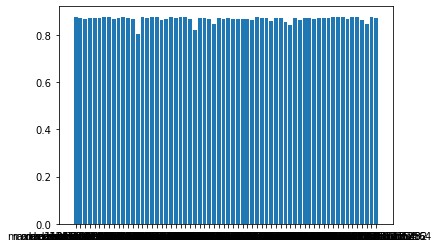

In [25]:
# Sort the dictionary by keys
sorted_data = dict(sorted(test_acc_dict.items()))

categories = list(sorted_data.keys())
values = list(sorted_data.values())

plt.bar(categories, values)
plt.xticks(rotate = 45)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of Sorted Data')
plt.legend(categories)
plt.show()


In [21]:
# Sort the dictionary by keys
sorted_data = dict(sorted(test_acc_dict.items()))

categories = list(sorted_data.keys())
values = list(sorted_data.values())

# Define color labels corresponding to each category
color_labels = {
    'Category1': 'red',
    'Category2': 'blue',
    'Category3': 'green',
    'Category4': 'orange'
}

# Create a bar chart with custom colors
bars = plt.bar(categories, values, color=[color_labels[category] for category in categories])

# Create a legend for the colors
legend_labels = [plt.Line2D([0], [0], color=color_labels[category], lw=4, label=category) for category in categories]
plt.legend(handles=legend_labels, title='Word Length Categories')

plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart with Legend for Word Length Categories')
plt.show()


KeyError: 'maxlen110lr0.0005unit128'